In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# Define the file path
file_path = 'mutual_fund_data/df_merged.csv'

# Read the DataFrame from the CSV file
dtype_spec = {
    'crsp_obj_cd': 'string',
    'si_obj_cd': 'string',
    'wbrger_obj_cd': 'string',
    'policy': 'string',
    'lipper_asset_cd': 'string',
    'lipper_class': 'string',
    'lipper_obj_cd': 'string'
}
df_merged = pd.read_csv(file_path, dtype=dtype_spec)

# Exclude rows where 'crsp_obj_cd' starts with 'I' or 'O'
excludes_i_o = ~df_merged['crsp_obj_cd'].str.startswith(('OM', 'OC', 'I'), na=False)

# Create a new DataFrame excluding the specified 'crsp_obj_cd' codes
df_merged = df_merged[excludes_i_o]
print(df_merged.shape)

# List of substrings to check for
# Appel et al 2016
substrings = [
    'Index', 'Idx', 'Indx', 'Ind ', 'Russell', 'S & P', 'S and P', 'S&P', 'SandP', 'SP ',
    'DOW', 'Dow', 'DJ', 'MSCI', 'Bloomberg', 'KBW', 'NASDAQ', 'NYSE', 'STOXX',
    'FTSE', 'Wilshire', 'Morningstar', '100', '400', '500', '600', '900', '1000',
    '1500', '2000', '5000'
]
print(df_merged.shape)
# Create the 'index' column
df_merged['index'] = df_merged['fund_name'].str.contains('|'.join(substrings), case=False).astype(int)

exclude_bond = ~df_merged['fund_name'].str.contains('bond', case=False, na=False)
df_merged = df_merged[exclude_bond]
# df_merged = df_merged[~((df_merged['index_fund_flag'] == 'D') | (df_merged['index'] == 1))]
# conditions_active = (
#     (df_merged['index_fund_flag'].isin(['B', 'E'])) &
#     (df_merged['index'] == 0)
# )
conditions_active = (
    (df_merged['index'] == 0)
)

# conditions_passive = (
#     (df_merged['index_fund_flag'] == 'D') |
#     (df_merged['index'] == 1)
# )
conditions_passive = (
    (df_merged['index'] == 1)
)



# Initialize fund type to 'Other', then set to 'Active' or 'Passive' based on conditions
df_merged['fund_type'] = 'Other'
df_merged.loc[conditions_active, 'fund_type'] = 'Active'
df_merged.loc[conditions_passive, 'fund_type'] = 'Passive'

# Split the DataFrame into active, passive, and other
active_funds = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']
other_funds= df_merged[df_merged['fund_type'] == 'Other']

# Display the results
print("Active Funds:")
print(active_funds.shape)

print("\nPassive Funds:")
print(passive_funds.shape)

# There are no other Funds

(4146336, 69)
(4146336, 69)
Active Funds:
(3731063, 71)

Passive Funds:
(393021, 71)


In [2]:
# # Calculate average value added in the second half of the observations by year
# df_merged['caldt'] = pd.to_datetime(df_merged['caldt'])

# def calculate_second_half_avg(group):
#     n = len(group)
#     half_n = n // 2
#     if half_n > 1:
#         second_half = group.iloc[half_n:]
#         return second_half.groupby(second_half['caldt'].dt.year)['vanguard_VA'].mean()
#     else:
#         return pd.Series()

# value_added_2nd_half = df_merged.groupby('crsp_fundno').apply(calculate_second_half_avg).reset_index()

# # Rename columns for merging
# value_added_2nd_half.columns = ['crsp_fundno', 'year', 'avg_value_added_2nd_half']

# # Merge the average value added by year to the main DataFrame
# df_merged = df_merged.merge(value_added_2nd_half, on=['crsp_fundno', 'year'], how='left')

# df_merged = df_merged.dropna(subset=['skill_ratio'])

# # Now decile on skill ratio
# deciles = pd.qcut(df_merged['skill_ratio'], 3, labels=False)
# df_merged['skill_ratio_decile'] = deciles

# # Group by year and decile and calculate the mean avg_value_added_2nd_half
# decile_yearly_avg_value_added = df_merged.groupby(['year', 'skill_ratio_decile'])['avg_value_added_2nd_half'].mean().unstack()

# # Plot the results
# plt.figure(figsize=(12, 8))
# for decile in decile_yearly_avg_value_added.columns:
#     plt.plot(decile_yearly_avg_value_added.index, decile_yearly_avg_value_added[decile], marker='o', label=f'Decile {decile + 1}')

# plt.title('Average Value Added in Second Half by Skill Ratio Decile and Year')
# plt.xlabel('Year')
# plt.ylabel('Average Value Added')
# plt.legend(title='Skill Ratio Decile')
# plt.grid(False)
# plt.show()

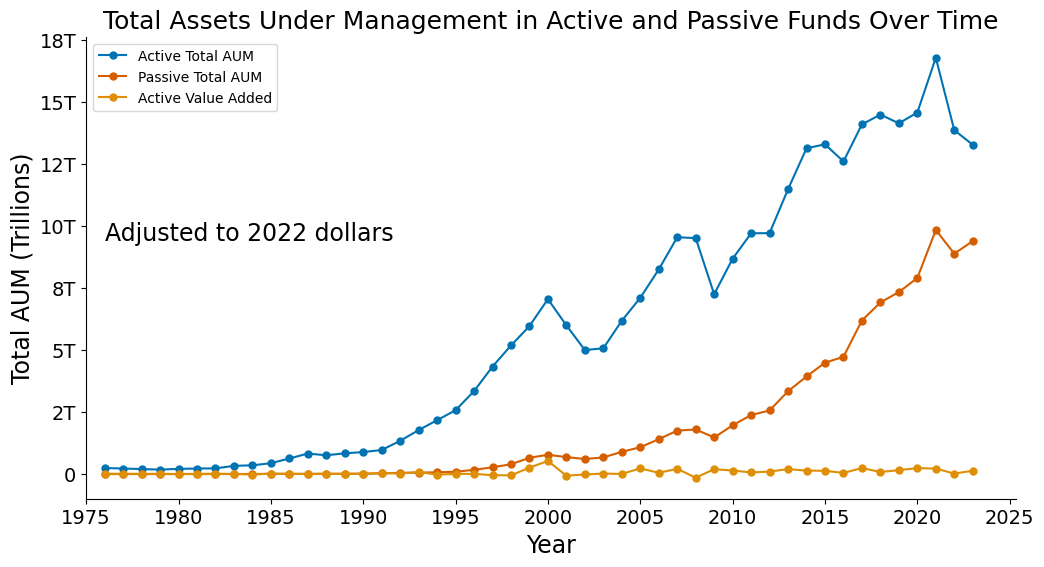

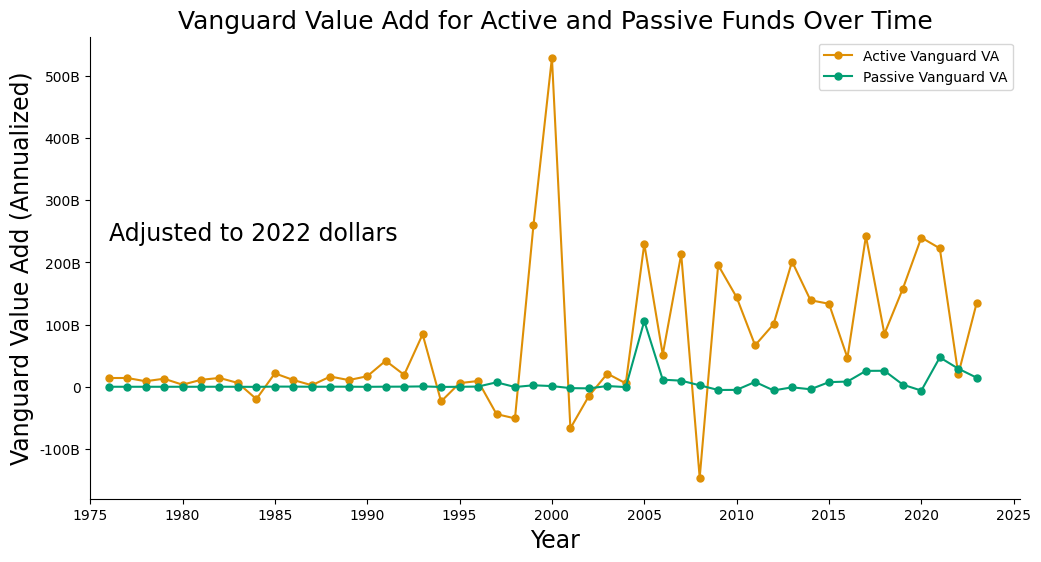

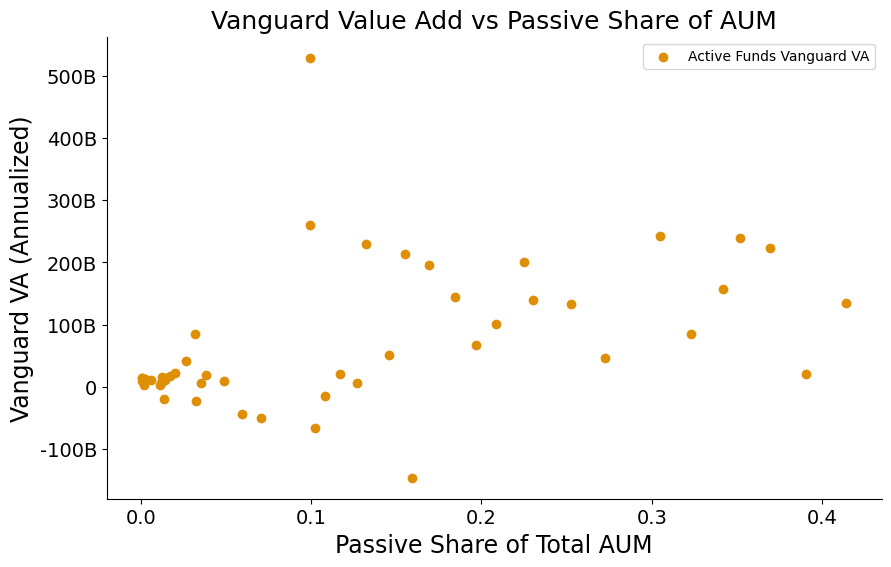

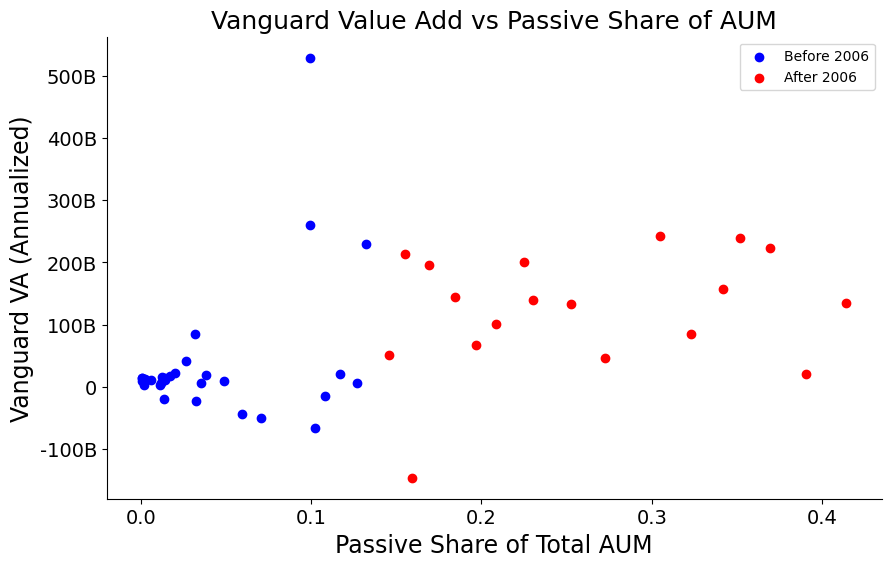

In [16]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
title_fontsize = 18
tick_label_fontsize = 14  # or any size you prefer
axes_label_fontsize = 17
sns.set_palette("colorblind")
color = sns.color_palette("colorblind")

# Define a color dictionary to map fund types to colors
colors = {
    'active_aum': color[0],
    'active_va': color[1],
    'passive_aum': color[3],
    'passive_va': color[2]
}
# Assuming df_merged is already created, read, and processed as described in your previous steps.

# Separate the data into active and passive funds
active_funds = df_merged[df_merged['fund_type'] == 'Active']
passive_funds = df_merged[df_merged['fund_type'] == 'Passive']

# Calculate metrics for active funds
num_active_funds = active_funds.groupby('year')['crsp_fundno'].nunique()
mean_active_assets_per_fund = active_funds.groupby('year')['mtna_adj2022'].mean()
active_ff_VA = active_funds.groupby('year')['ff_VA'].mean()
active_vanguard_VA = active_funds.groupby('year')['vanguard_VA'].mean()
turn_ratio = active_funds.groupby('year')['turn_ratio'].mean()

active_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_active_funds,
    'mean_assets_per_fund': mean_active_assets_per_fund,
    'ff_monthly_mean_VA': active_ff_VA,
    'vanguard_monthly_mean_VA': active_vanguard_VA,
    'turn_ratio': turn_ratio
}).reset_index()

active_df_by_year['total_aum_in_funds'] = active_df_by_year['num_funds_each_year'] * active_df_by_year['mean_assets_per_fund'] * 1000000
active_df_by_year['ff_VA_tot'] = active_df_by_year['ff_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']
active_df_by_year['vanguard_VA_tot'] = active_df_by_year['vanguard_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']

# Calculate metrics for passive funds
num_passive_funds = passive_funds.groupby('year')['crsp_fundno'].nunique()
mean_passive_assets_per_fund = passive_funds.groupby('year')['mtna_adj2022'].mean()
passive_ff_VA = passive_funds.groupby('year')['ff_VA'].mean()
passive_vanguard_VA = passive_funds.groupby('year')['vanguard_VA'].mean()

passive_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_passive_funds,
    'mean_assets_per_fund': mean_passive_assets_per_fund,
    'ff_monthly_mean_VA': passive_ff_VA,
    'vanguard_monthly_mean_VA': passive_vanguard_VA
}).reset_index()

passive_df_by_year['total_aum_in_funds'] = passive_df_by_year['num_funds_each_year'] * passive_df_by_year['mean_assets_per_fund'] * 1000000
passive_df_by_year['ff_VA_tot'] = passive_df_by_year['ff_monthly_mean_VA'] * 12 * passive_df_by_year['num_funds_each_year']
passive_df_by_year['vanguard_VA_tot'] = passive_df_by_year['vanguard_monthly_mean_VA'] * 12 * passive_df_by_year['num_funds_each_year']


# Calculate metrics for other funds
num_other_funds = other_funds.groupby('year')['crsp_fundno'].nunique()
mean_other_assets_per_fund = other_funds.groupby('year')['mtna_adj2022'].mean()
other_ff_VA = other_funds.groupby('year')['ff_VA'].mean()
other_vanguard_VA = other_funds.groupby('year')['vanguard_VA'].mean()

other_df_by_year = pd.DataFrame({
    'num_funds_each_year': num_other_funds,
    'mean_assets_per_fund': mean_other_assets_per_fund,
    'ff_monthly_mean_VA': other_ff_VA,
    'vanguard_monthly_mean_VA': other_vanguard_VA
}).reset_index()

other_df_by_year['total_aum_in_funds'] = other_df_by_year['num_funds_each_year'] * other_df_by_year['mean_assets_per_fund'] * 1000000
other_df_by_year['ff_VA_tot'] = other_df_by_year['ff_monthly_mean_VA'] * 12 * other_df_by_year['num_funds_each_year']
other_df_by_year['vanguard_VA_tot'] = other_df_by_year['vanguard_monthly_mean_VA'] * 12 * other_df_by_year['num_funds_each_year']

# Define billions and trillions formatters
def billions(x, pos):
    if x == 0:
        return '0'
    return f'{x * 1e-9:.0f}B'  # convert to billions

def trillions(x, pos):
    if x == 0:
        return '0'
    else:
        return f'{x * 1e-12:.0f}T'

# Create formatter
formatter = FuncFormatter(trillions)

# Plot AUM for Active and Passive funds by year
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year['year'], active_df_by_year['total_aum_in_funds'], marker='o', markersize=5, label="Active Total AUM", color=colors['active_aum'])
plt.plot(passive_df_by_year['year'], passive_df_by_year['total_aum_in_funds'], marker='o', markersize=5, label="Passive Total AUM", color=colors['passive_aum'])
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Active Value Added", color=colors['active_va'])

plt.title('Total Assets Under Management in Active and Passive Funds Over Time', fontsize=title_fontsize)
plt.xlabel('Year', fontsize=axes_label_fontsize)
plt.ylabel('Total AUM (Trillions)', fontsize=axes_label_fontsize)
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter
plt.text(0.02, 0.6, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=axes_label_fontsize, verticalalignment='top', bbox=None)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.xticks(fontsize=tick_label_fontsize)
plt.yticks(fontsize=tick_label_fontsize)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_aum.pdf')
plt.show()
formatter = FuncFormatter(billions)

# Plot Vanguard Value Add for Active and Passive funds by year
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Active Vanguard VA", color=colors['active_va'])
plt.plot(passive_df_by_year['year'], passive_df_by_year['vanguard_VA_tot'], marker='o', markersize=5, label="Passive Vanguard VA", color=colors['passive_va'])

# Titles and Labels
plt.title('Vanguard Value Add for Active and Passive Funds Over Time', fontsize=title_fontsize)
plt.xlabel('Year', fontsize=axes_label_fontsize)
plt.ylabel('Vanguard Value Add (Annualized)', fontsize=axes_label_fontsize)
plt.text(0.02, 0.6, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=axes_label_fontsize, verticalalignment='top', bbox=None)
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_vanguard_va.pdf')
plt.show()


# Calculate Passive Share of AUM
passive_df_by_year['passive_share'] = passive_df_by_year['total_aum_in_funds'] / (
    passive_df_by_year['total_aum_in_funds'] + active_df_by_year['total_aum_in_funds']
)

# Combine dataframes for plotting (assuming years are aligned)
combined_df = active_df_by_year[['year', 'vanguard_VA_tot']].copy()
combined_df['passive_share'] = passive_df_by_year['passive_share']

# Plot two-way scatter: Vanguard VA (Active Funds) vs Passive Share
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['passive_share'], combined_df['vanguard_VA_tot'], color=colors['active_va'], label='Active Funds Vanguard VA')

# coef = np.polyfit(combined_df['passive_share'], combined_df['vanguard_VA_tot'], 1)
# poly1d_fn = np.poly1d(coef)
# plt.plot(combined_df['passive_share'], poly1d_fn(combined_df['passive_share']), '--k', label='Best Fit Line')

plt.title('Vanguard Value Add vs Passive Share of AUM', fontsize=title_fontsize)
plt.xlabel('Passive Share of Total AUM', fontsize=axes_label_fontsize)
plt.ylabel('Vanguard VA (Annualized)', fontsize=axes_label_fontsize)
plt.gca().yaxis.set_major_formatter(formatter)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=tick_label_fontsize)
plt.yticks(fontsize=tick_label_fontsize)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_share_vanguard_va.pdf')
plt.show()


# Define new colors for the points before and after 2000
color_before_2000 = 'blue'
color_after_2000 = 'red'

# Separate the data into two subsets
before_2000 = combined_df[combined_df['year'] < 2006]
after_2000 = combined_df[combined_df['year'] >= 2006]

# Plot two-way scatter: Vanguard VA (Active Funds) vs Passive Share
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(before_2000['passive_share'], before_2000['vanguard_VA_tot'], color=color_before_2000, label='Before 2006')
plt.scatter(after_2000['passive_share'], after_2000['vanguard_VA_tot'], color=color_after_2000, label='After 2006')

# Fit a line of best fit for before 2000
coef_before = np.polyfit(before_2000['passive_share'], before_2000['vanguard_VA_tot'], 1)
poly1d_fn_before = np.poly1d(coef_before)
# plt.plot(before_2000['passive_share'], poly1d_fn_before(before_2000['passive_share']), linestyle='--', color='darkblue', label='Best Fit (Before 2000)')

# Fit a line of best fit for after 2000
coef_after = np.polyfit(after_2000['passive_share'], after_2000['vanguard_VA_tot'], 1)
poly1d_fn_after = np.poly1d(coef_after)
# plt.plot(after_2000['passive_share'], poly1d_fn_after(after_2000['passive_share']), linestyle='--', color='darkred', label='Best Fit (After 2000)')

# Titles and Labels
plt.title('Vanguard Value Add vs Passive Share of AUM', fontsize=title_fontsize)
plt.xlabel('Passive Share of Total AUM', fontsize=axes_label_fontsize)
plt.ylabel('Vanguard VA (Annualized)', fontsize=axes_label_fontsize)

ax = plt.gca()
plt.gca().yaxis.set_major_formatter(formatter)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(fontsize=tick_label_fontsize)
plt.yticks(fontsize=tick_label_fontsize)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_passive_share_vanguard_va_pre_post.pdf')
plt.show()

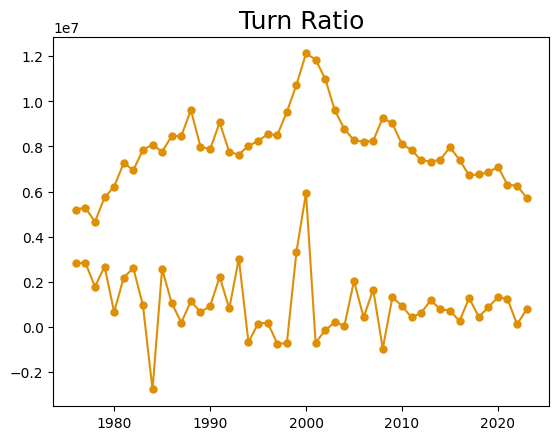

In [4]:
plt.title('Turn Ratio', fontsize=title_fontsize)
plt.plot(active_df_by_year['year'], 10000000*active_df_by_year['turn_ratio'], marker='o', markersize=5, label="Active Vanguard VA", color=colors['active_va'])
plt.plot(active_df_by_year['year'], active_df_by_year['vanguard_monthly_mean_VA'], marker='o', markersize=5, label="Active Vanguard VA", color=colors['active_va'])


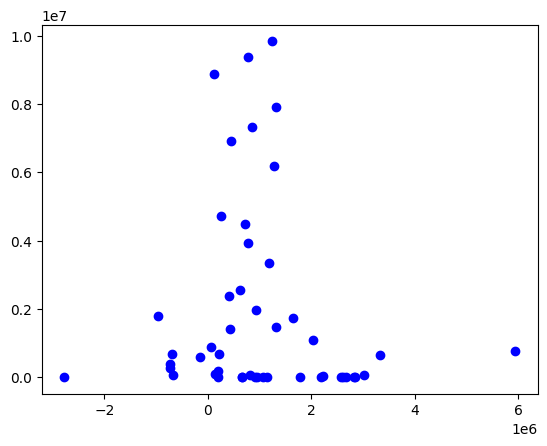

In [5]:
plt.scatter(active_df_by_year['vanguard_monthly_mean_VA'], passive_df_by_year['num_funds_each_year']*passive_df_by_year['mean_assets_per_fund'], color='blue', marker='o')


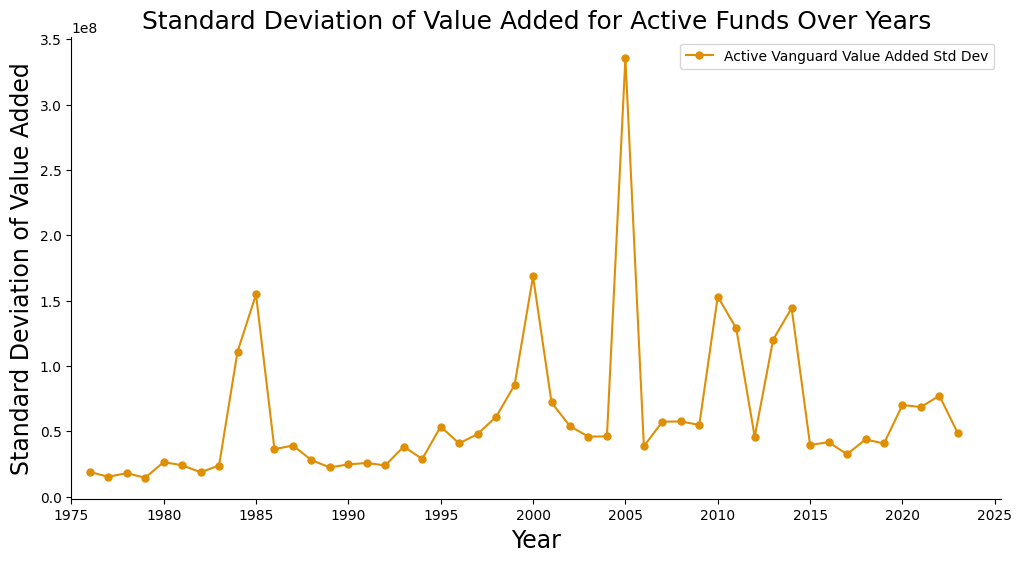

In [6]:
active_ff_VA_std = active_funds.groupby('year')['ff_VA'].std()
active_vanguard_VA_std = active_funds.groupby('year')['vanguard_VA'].std()

active_df_by_year_std = pd.DataFrame({
    'ff_VA_std': active_ff_VA_std,
    'vanguard_VA_std': active_vanguard_VA_std
}).reset_index()


plt.figure(figsize=(12, 6))
# plt.plot(active_df_by_year_std['year'], active_df_by_year_std['ff_VA_std'], marker='o', markersize=5, label="Active FF Value Added Std Dev", color='tab:blue')
plt.plot(active_df_by_year_std['year'], active_df_by_year_std['vanguard_VA_std'], marker='o', markersize=5, label="Active Vanguard Value Added Std Dev",color=colors['active_va'])

# Titles and Labels
plt.title('Standard Deviation of Value Added for Active Funds Over Years', fontsize=title_fontsize)
plt.xlabel('Year', fontsize=axes_label_fontsize)
plt.ylabel('Standard Deviation of Value Added', fontsize=axes_label_fontsize)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/active_funds_value_added_std_dev.pdf')
plt.show()

/var/folders/bj/cqz9v_7s4pxcpym130bfjj0w0000gr/T/ipykernel_4670/3524716337.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_funds['vanguard_VA_winsorized'] = active_funds.groupby('year')['vanguard_VA'].transform(


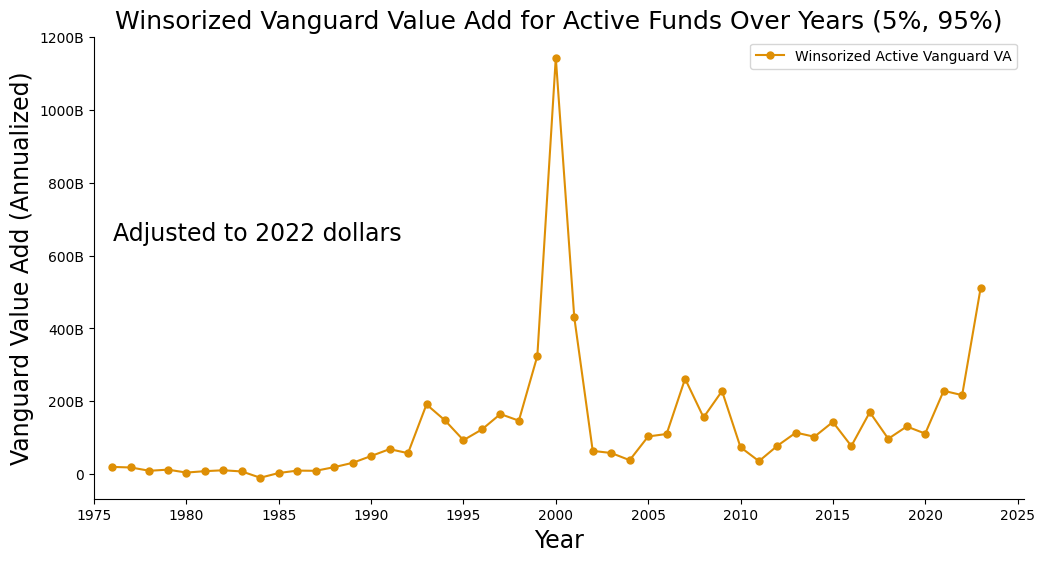

In [7]:

from scipy.stats import mstats

# Winsorizing function
def winsorize_series(series, limits):
    return mstats.winsorize(series, limits=limits)

# Apply winsorizing to active Vanguard VA with limits at the 05th and 95th percentiles
active_funds['vanguard_VA_winsorized'] = active_funds.groupby('year')['vanguard_VA'].transform(
    lambda x: winsorize_series(x, limits=(0.05, 0.05))
)
active_vanguard_VA_winsorized = active_funds.groupby('year')['vanguard_VA_winsorized'].mean()

# Create a new DataFrame for the winsorized active data by year
active_df_by_year_winsorized = pd.DataFrame({
    'num_funds_each_year': num_active_funds,
    'mean_assets_per_fund': mean_active_assets_per_fund,
    'ff_monthly_mean_VA': active_ff_VA,
    'vanguard_monthly_mean_VA': active_vanguard_VA,
    'vanguard_monthly_mean_VA_winsorized': active_vanguard_VA_winsorized
}).reset_index()

active_df_by_year_winsorized['total_aum_in_funds'] = active_df_by_year['num_funds_each_year'] * active_df_by_year['mean_assets_per_fund'] * 1000000
active_df_by_year_winsorized['ff_VA_tot'] = active_df_by_year['ff_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']
active_df_by_year_winsorized['vanguard_VA_tot'] = active_df_by_year['vanguard_monthly_mean_VA'] * 12 * active_df_by_year['num_funds_each_year']
active_df_by_year_winsorized['vanguard_VA_tot_winsorized'] = active_df_by_year_winsorized['vanguard_monthly_mean_VA_winsorized'] * 12 * active_df_by_year_winsorized['num_funds_each_year']
plt.figure(figsize=(12, 6))
plt.plot(active_df_by_year_winsorized['year'], active_df_by_year_winsorized['vanguard_VA_tot_winsorized'], marker='o', markersize=5, label="Winsorized Active Vanguard VA", color=colors['active_va'])
plt.title('Winsorized Vanguard Value Add for Active Funds Over Years (5%, 95%)', fontsize=title_fontsize)
plt.xlabel('Year', fontsize=axes_label_fontsize)
plt.ylabel('Vanguard Value Add (Annualized)', fontsize=axes_label_fontsize)
plt.text(0.02, 0.6, 'Adjusted to 2022 dollars', transform=plt.gca().transAxes,
         fontsize=axes_label_fontsize, verticalalignment='top', bbox=None)
plt.gca().yaxis.set_major_formatter(formatter)  # apply formatter

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.set_xticks(range(1965, 2026, 5))
ax.set_xlim(left=1975)
plt.grid(False)
plt.legend()
plt.savefig('figures/winsorized_active_vanguard_va.pdf')
plt.show()

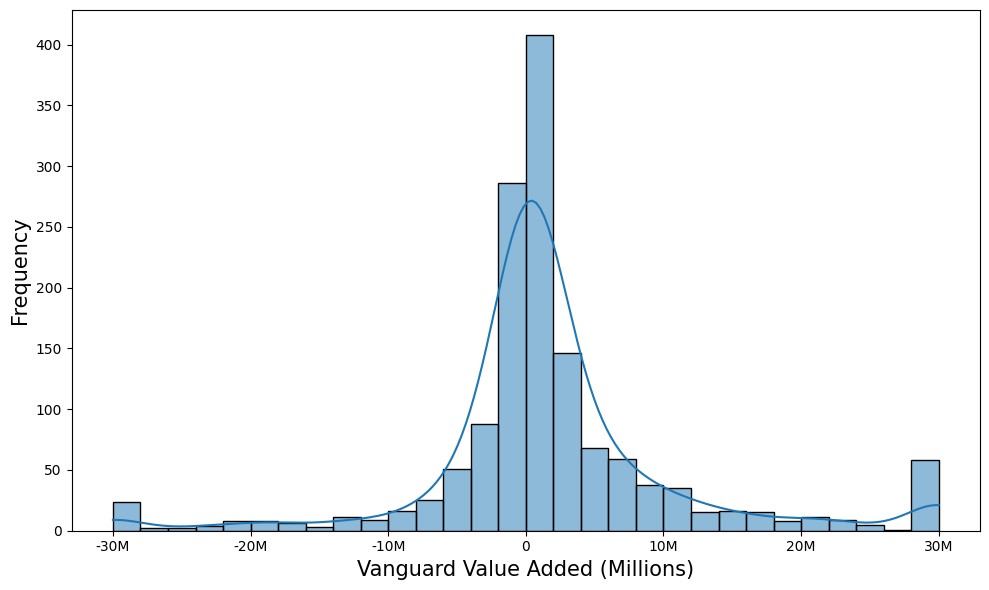

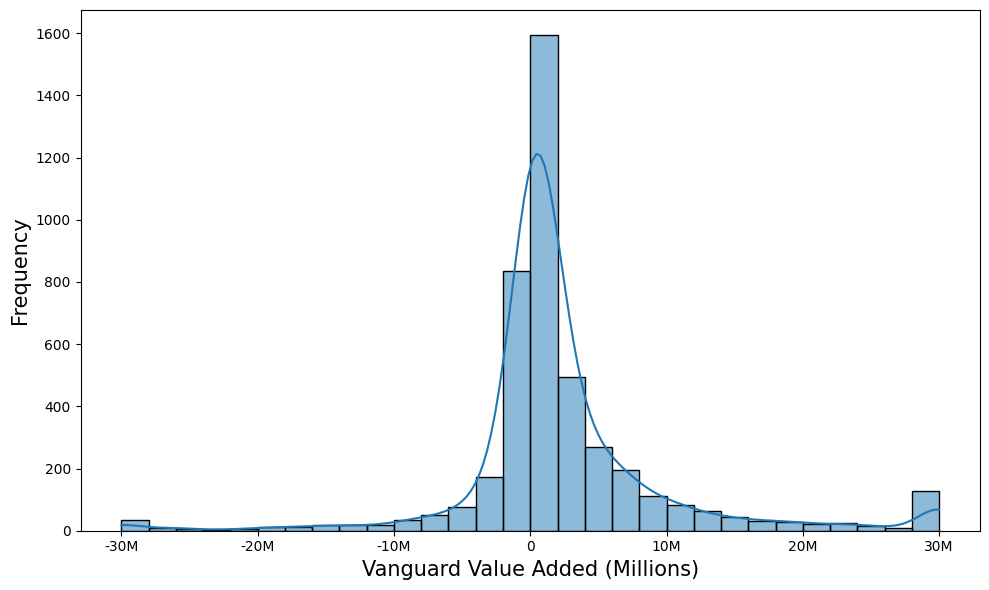

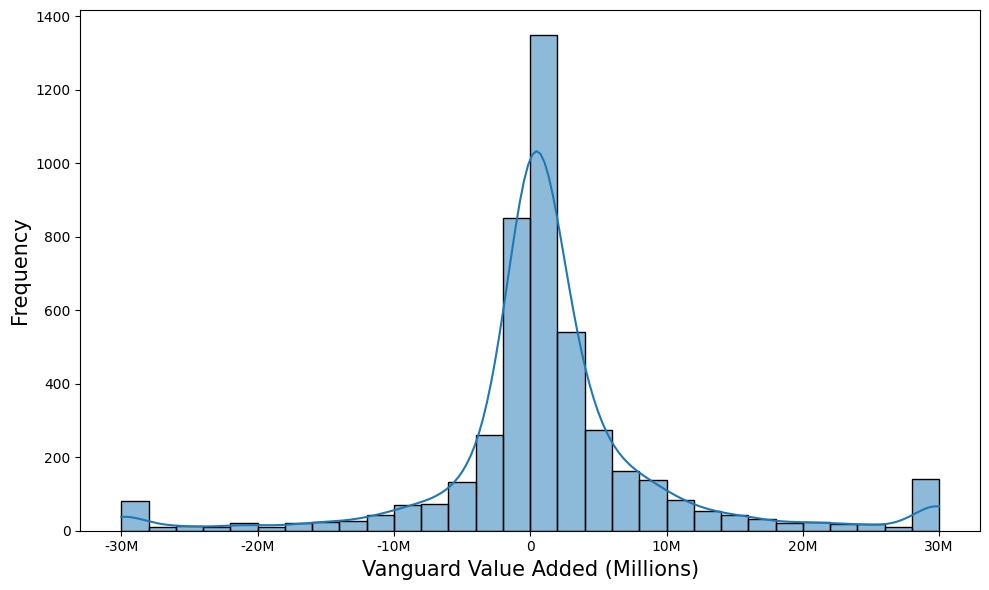

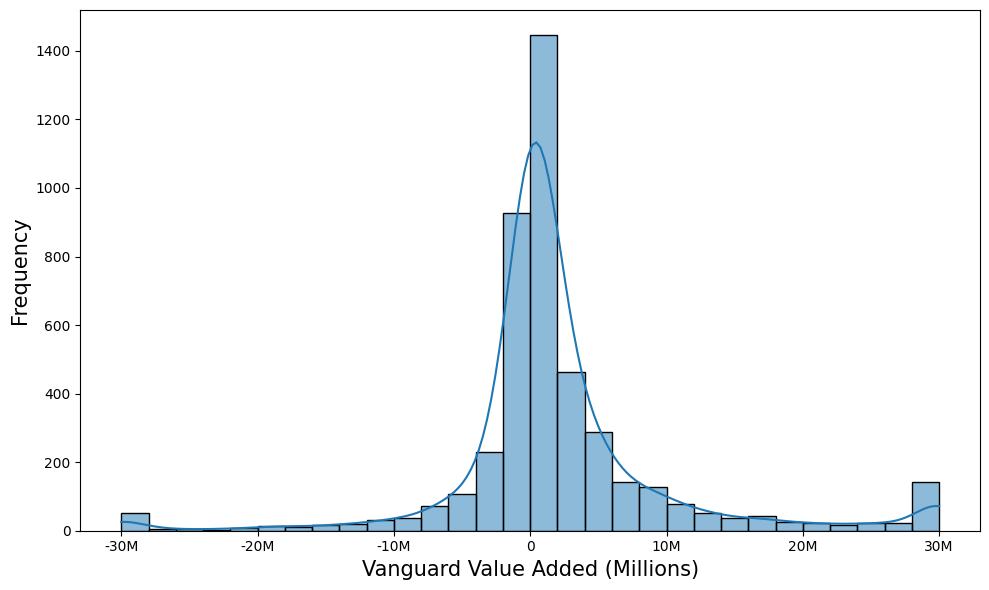

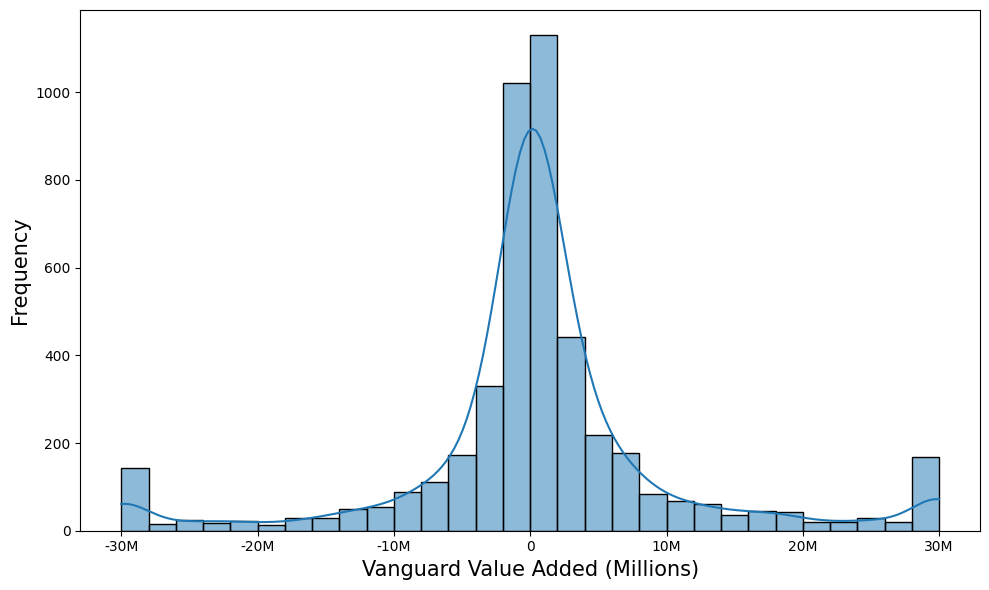

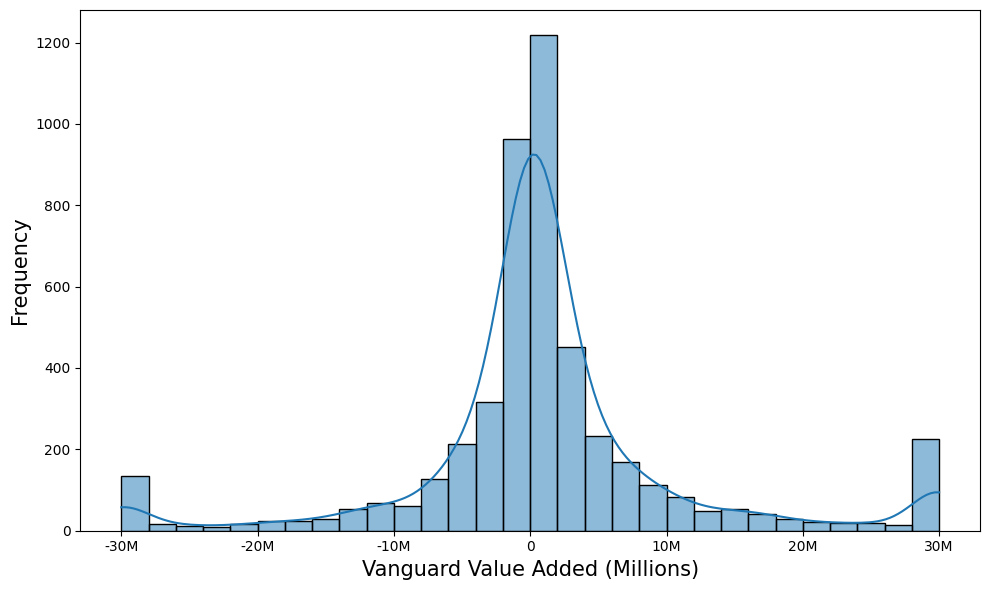

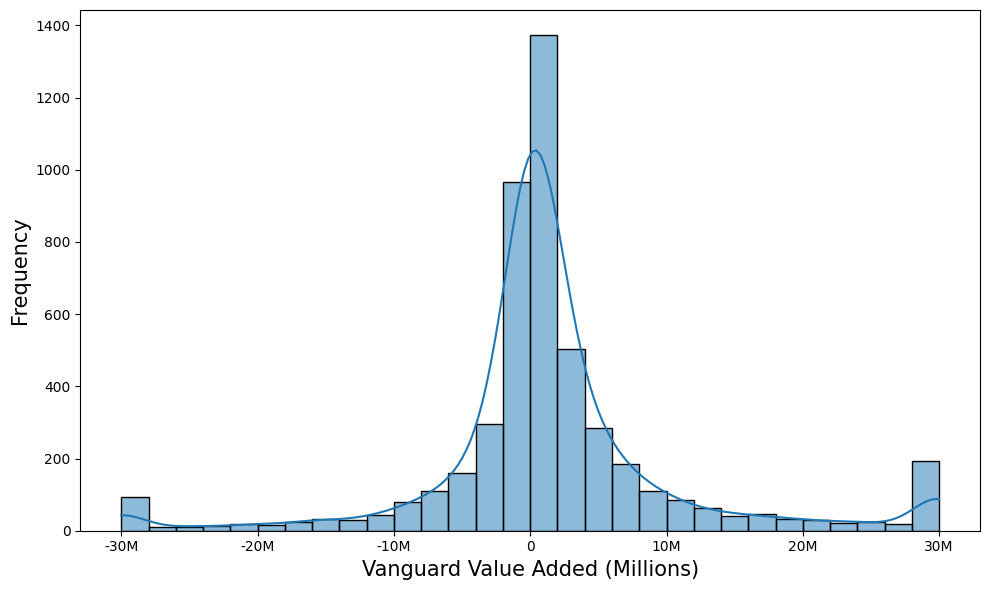

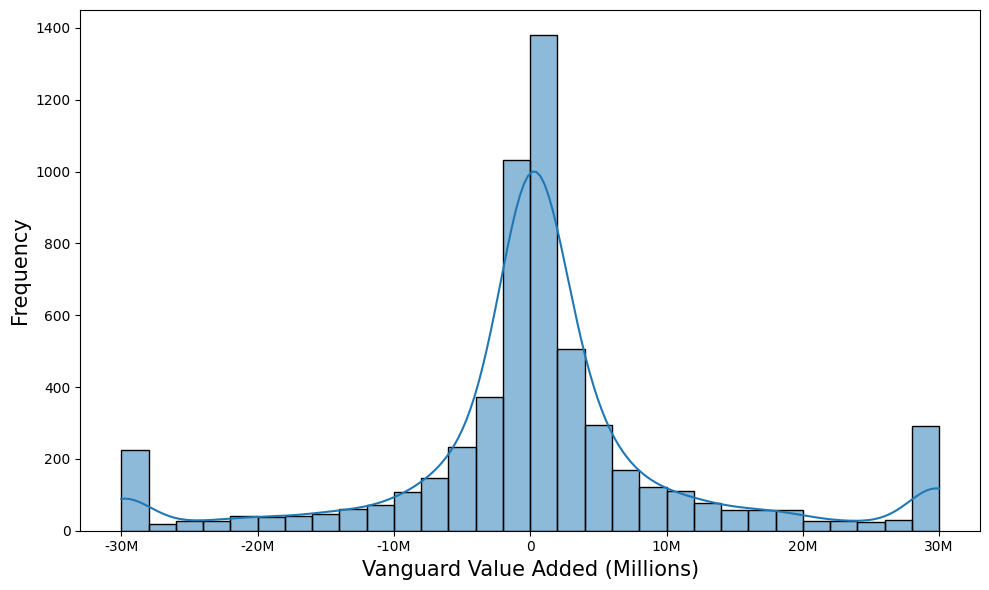

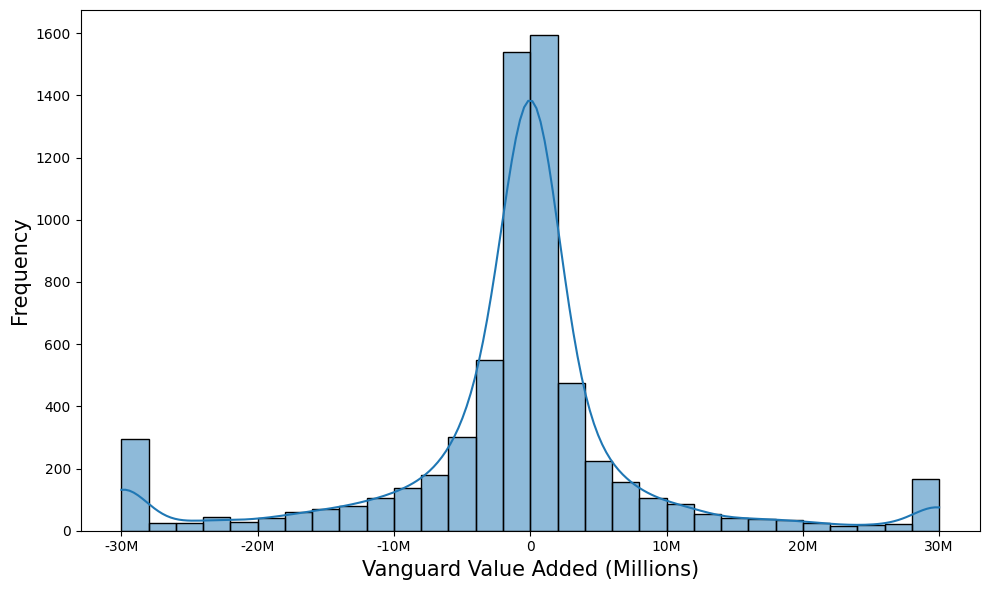

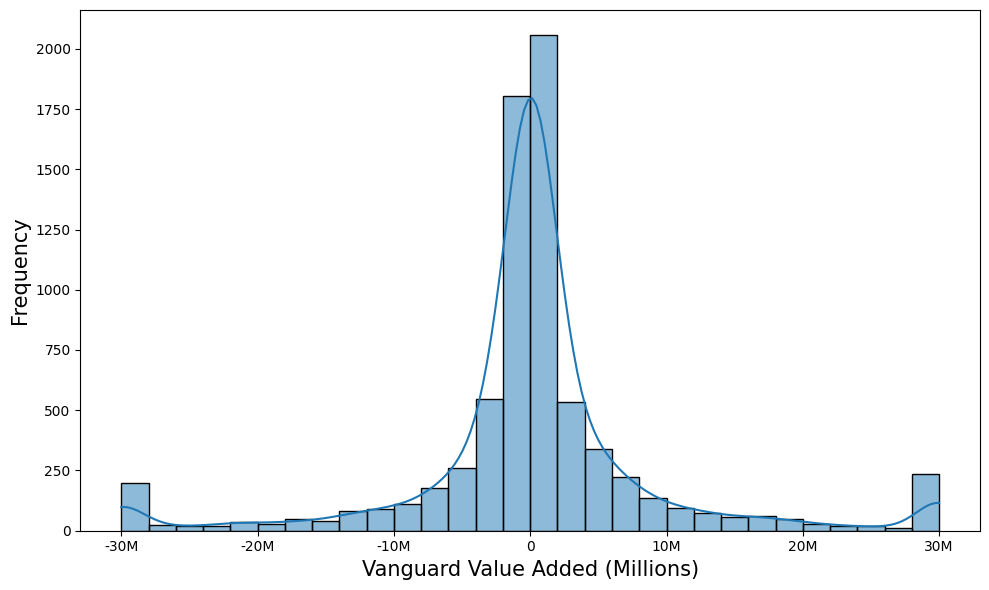

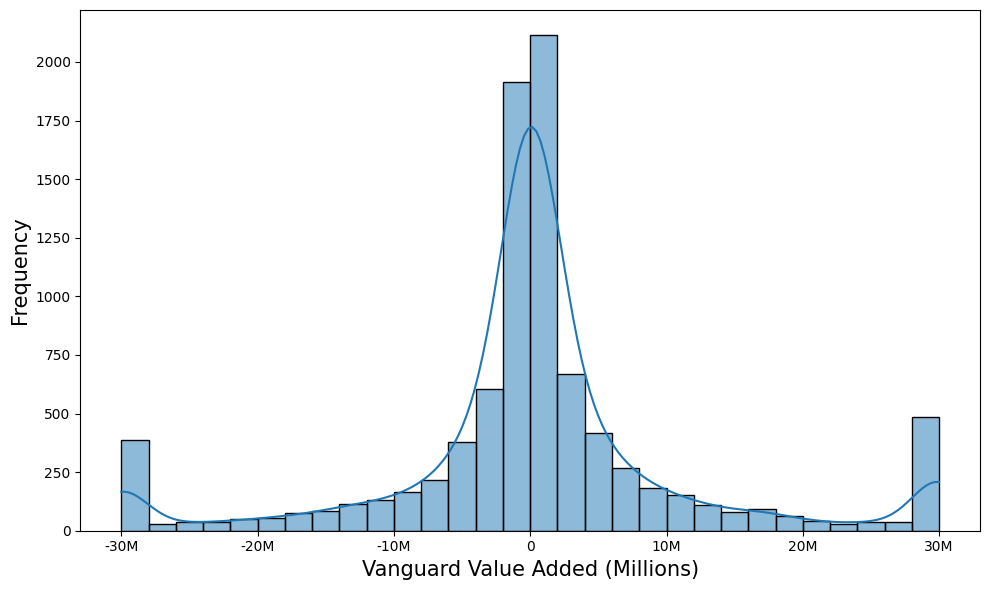

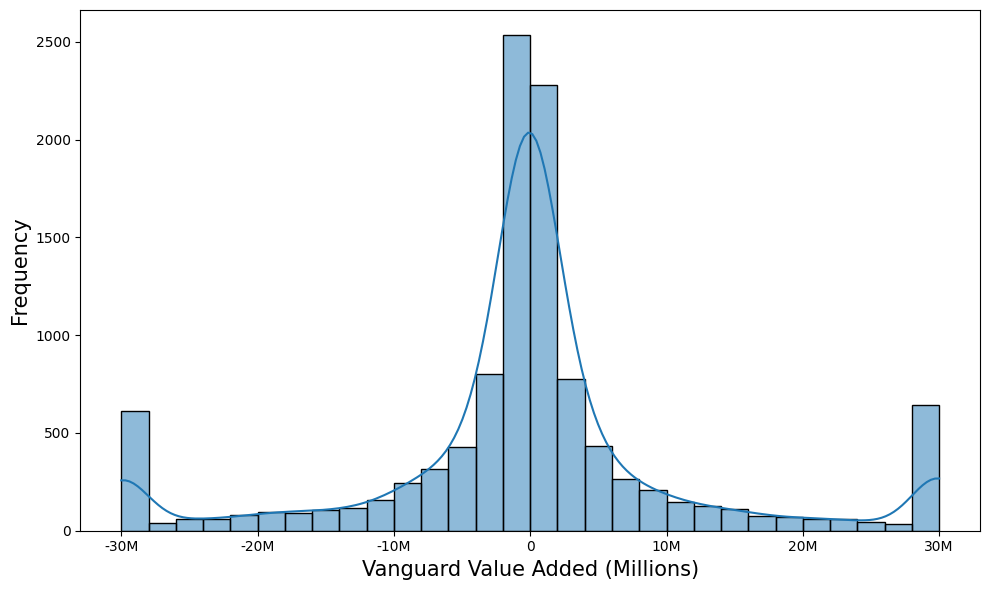

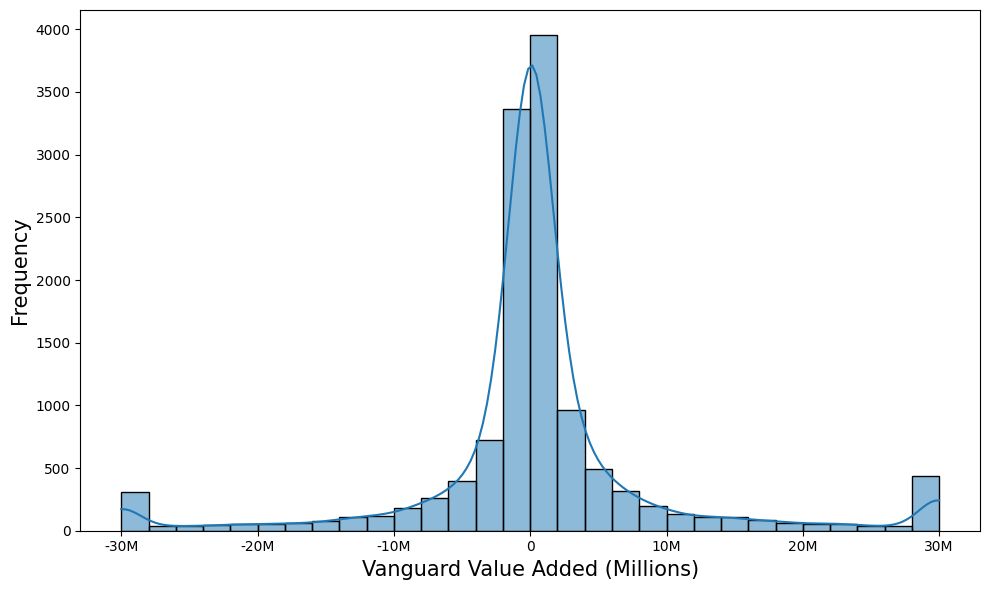

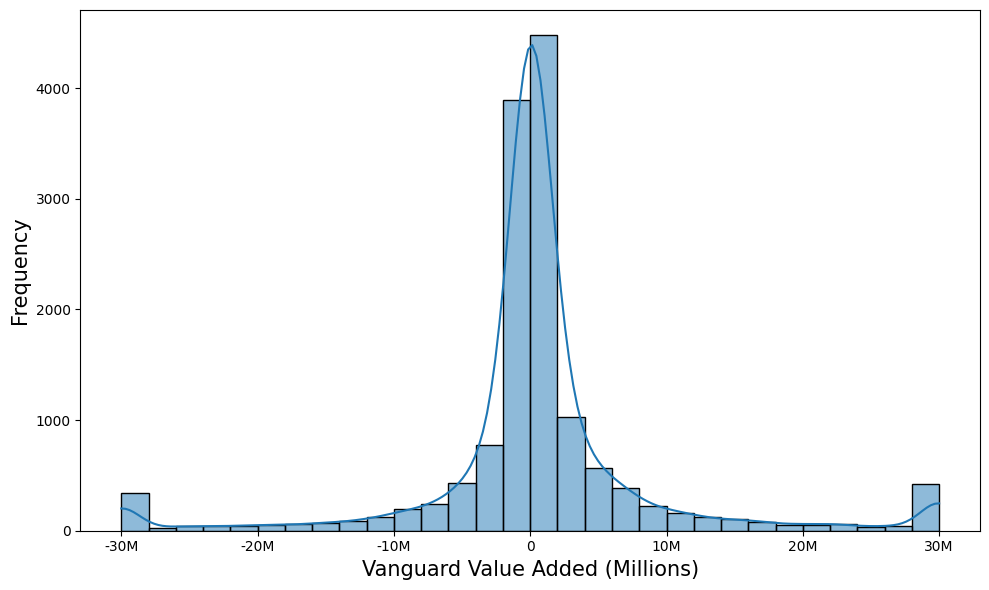

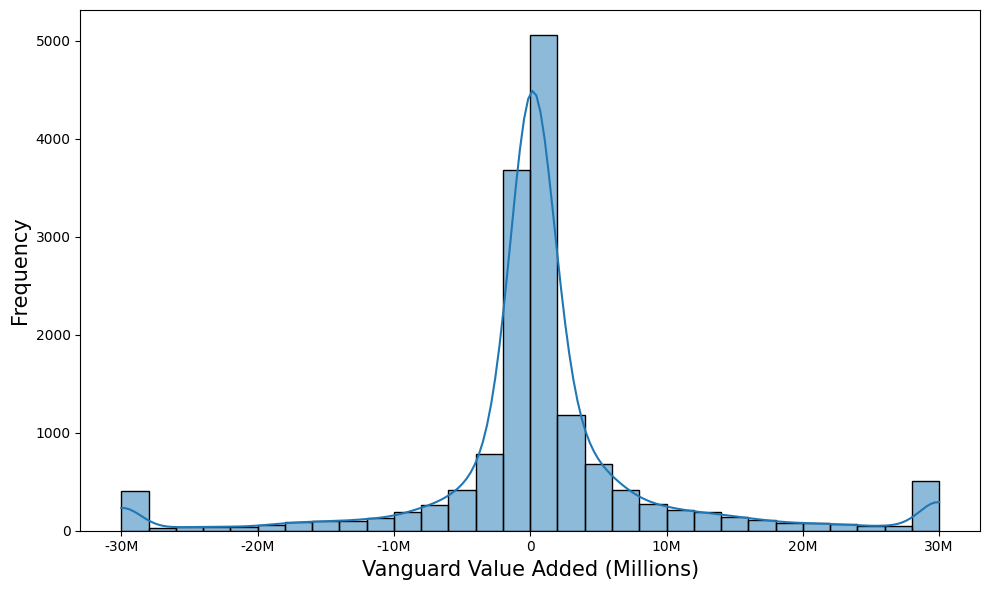

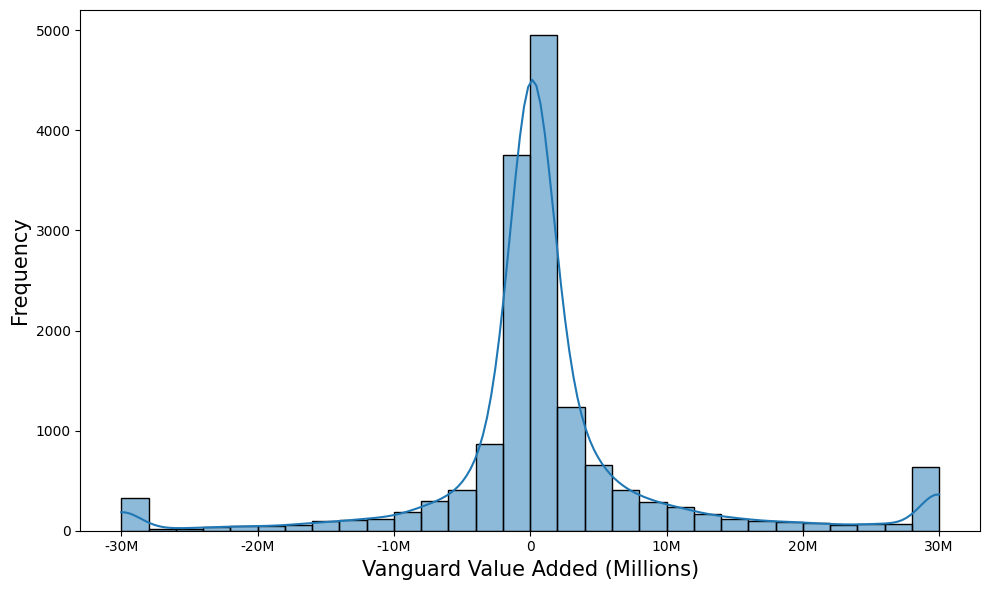

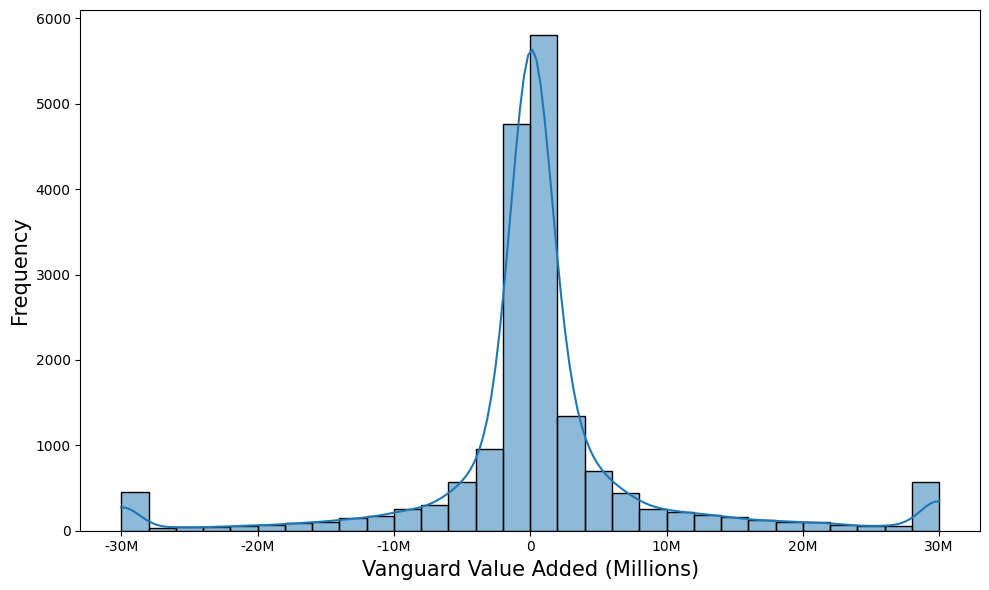

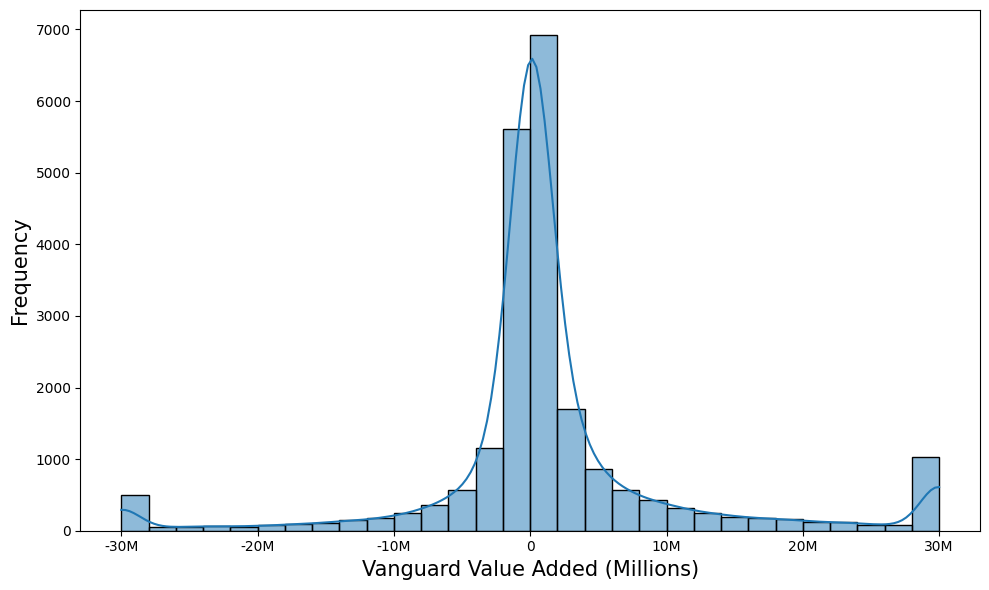

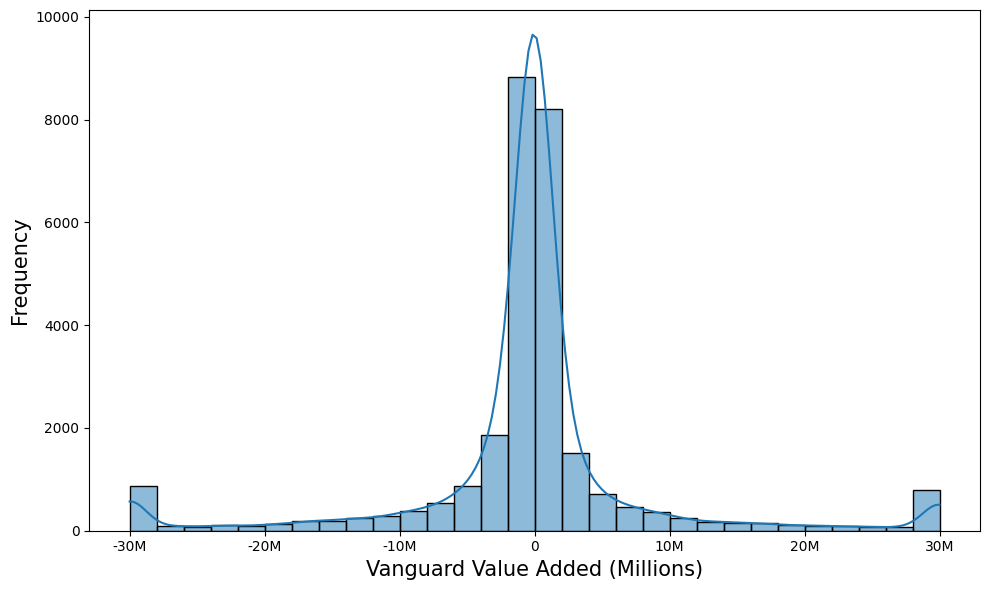

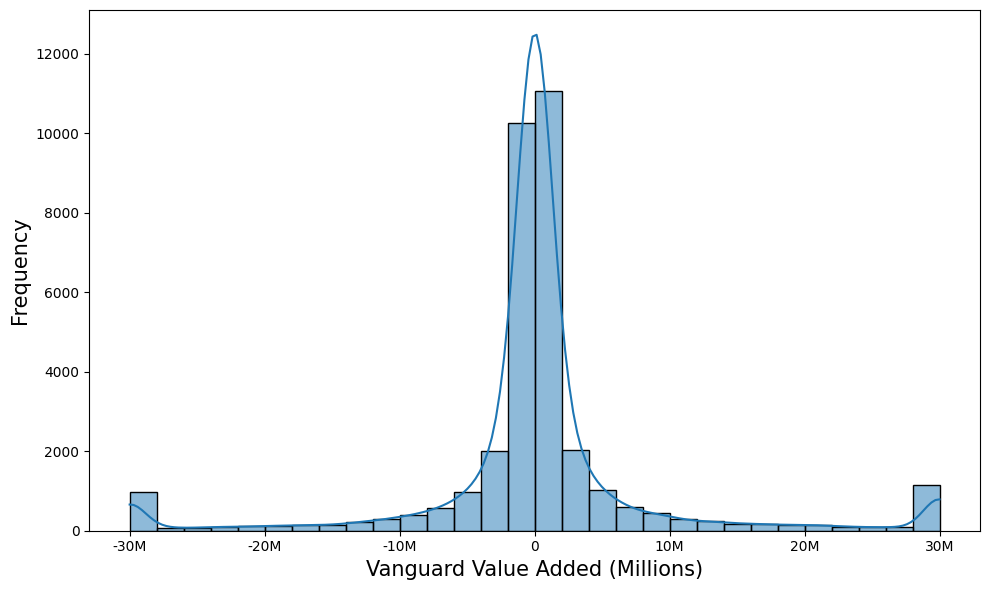

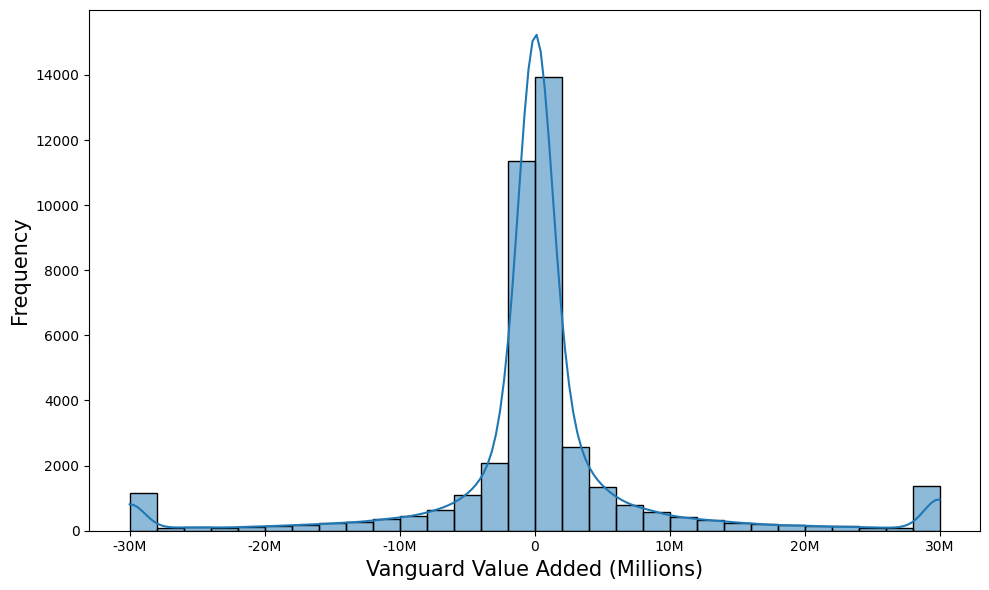

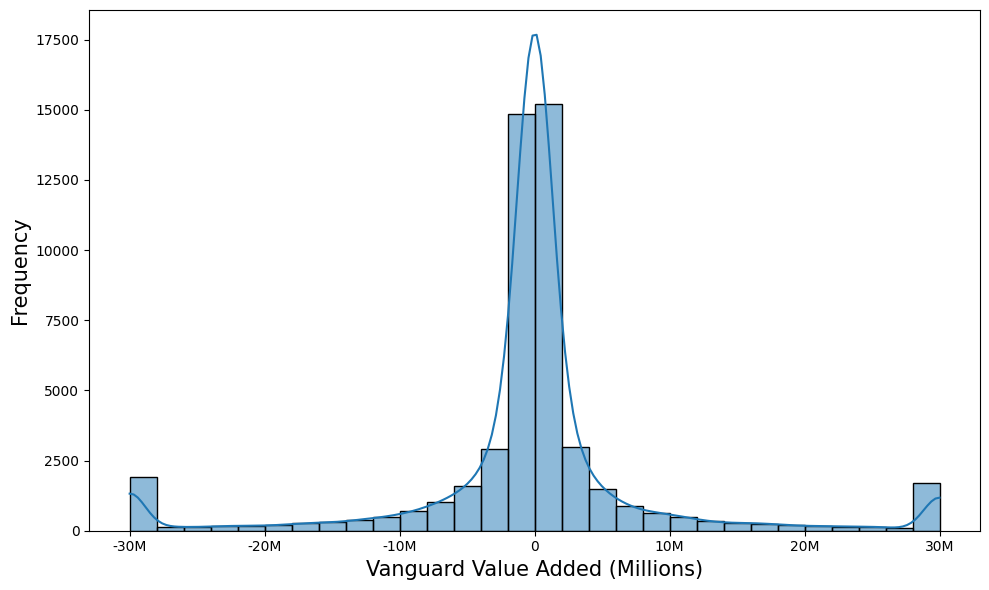

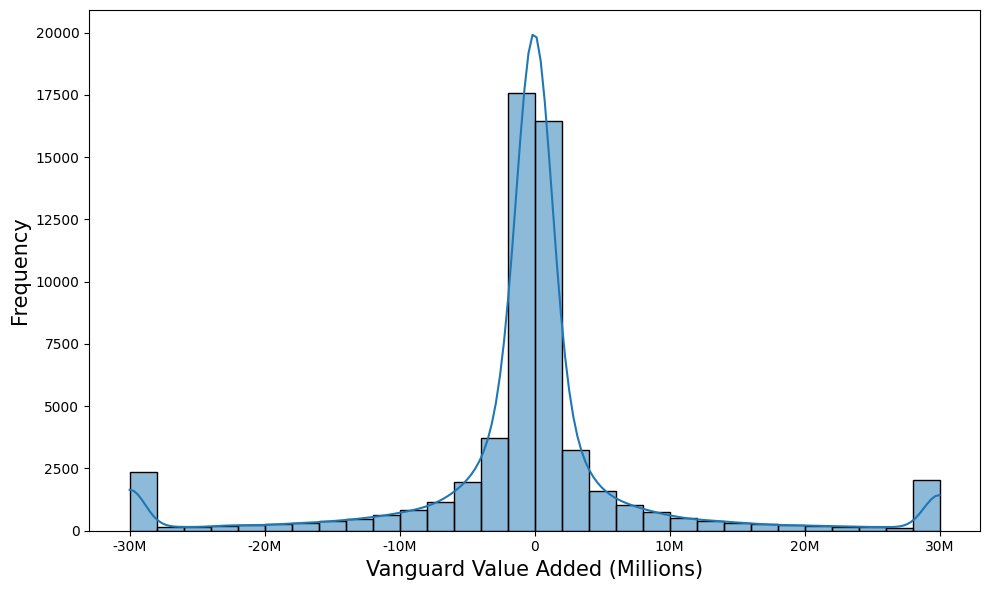

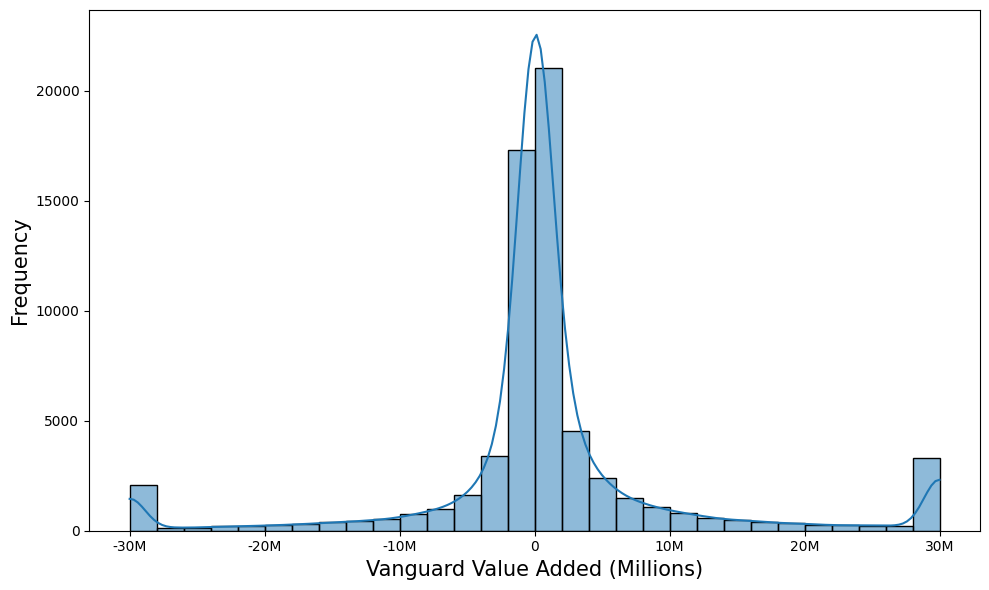

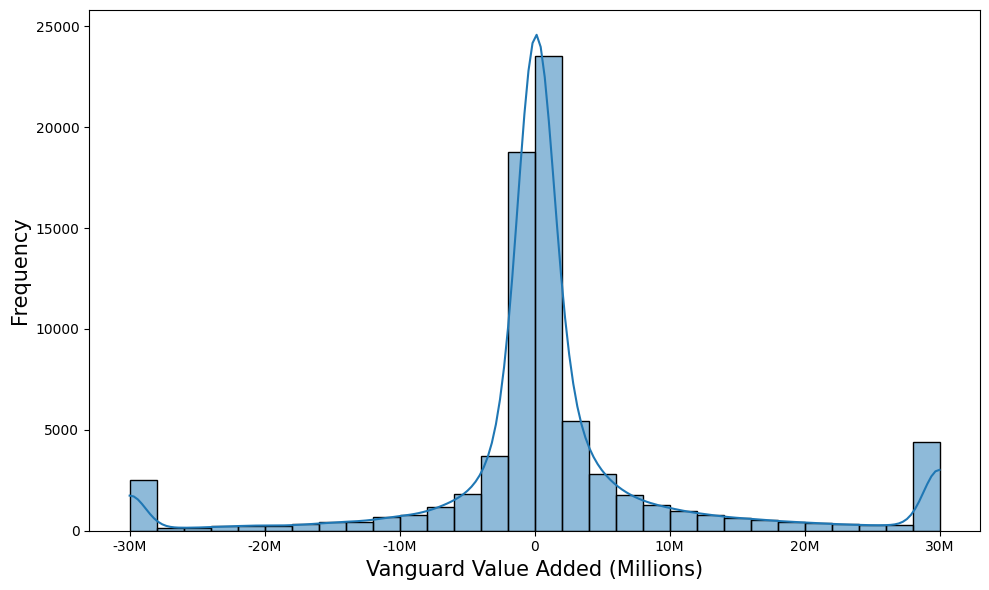

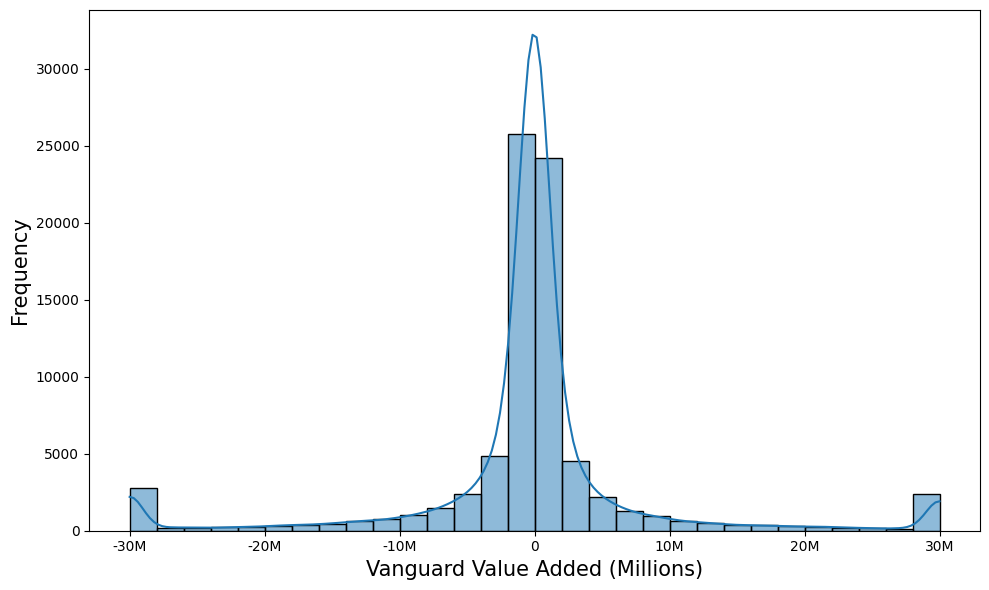

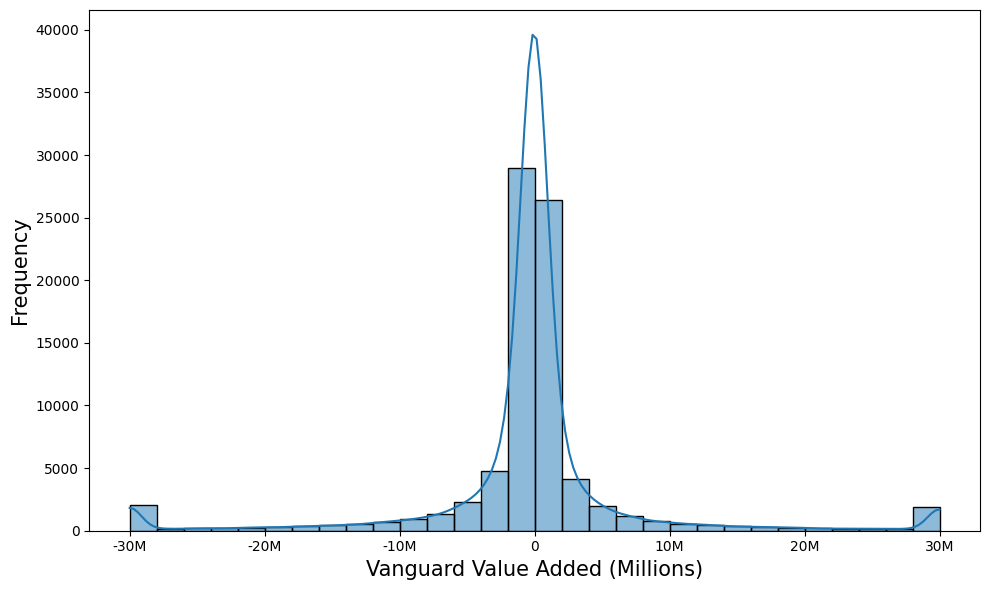

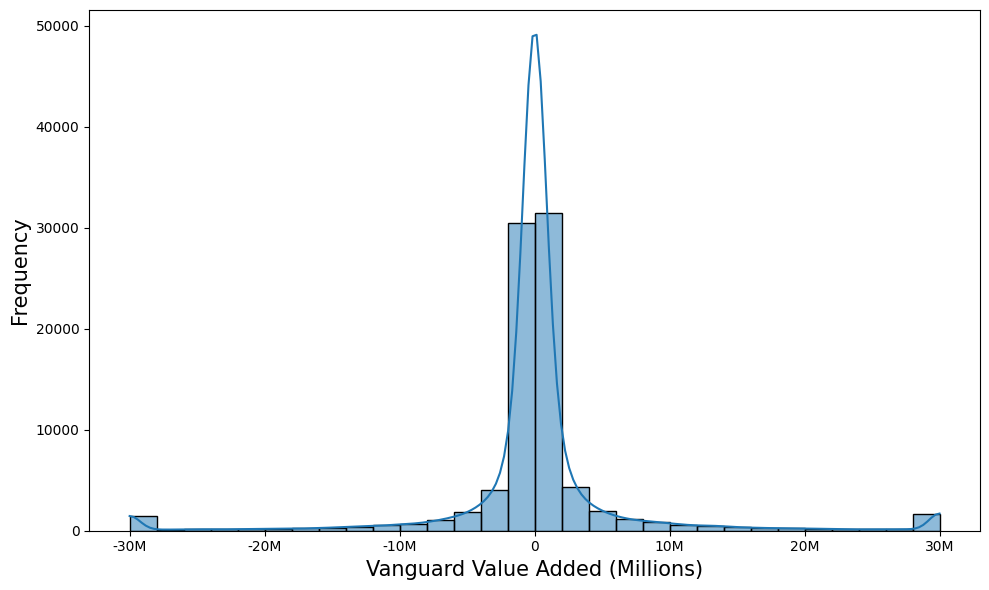

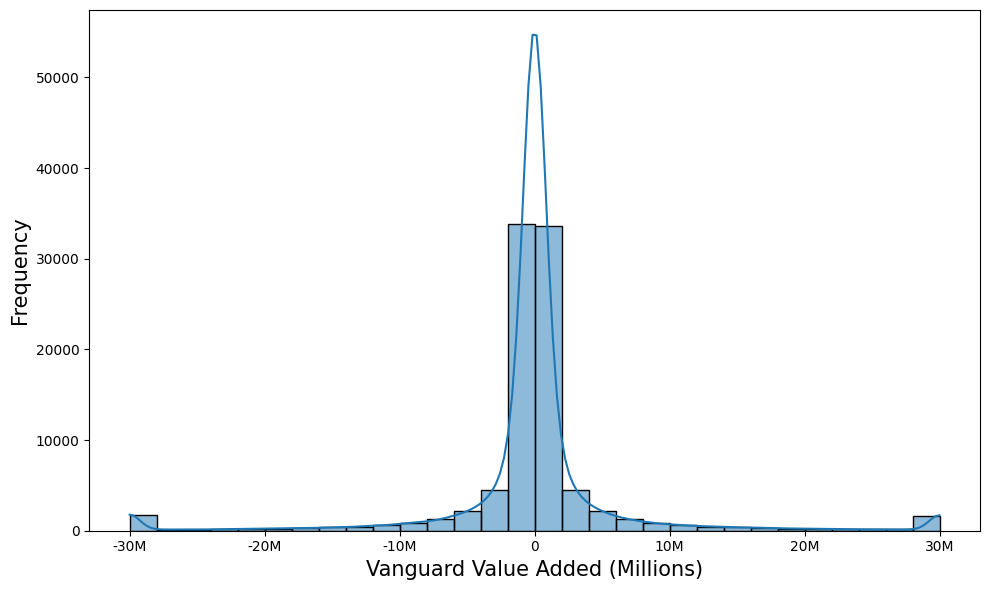

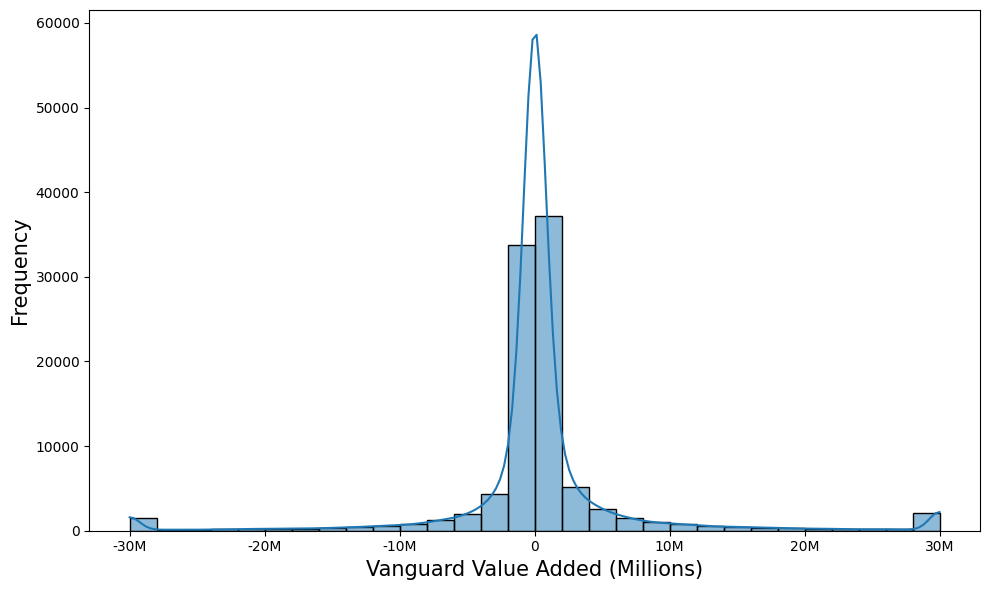

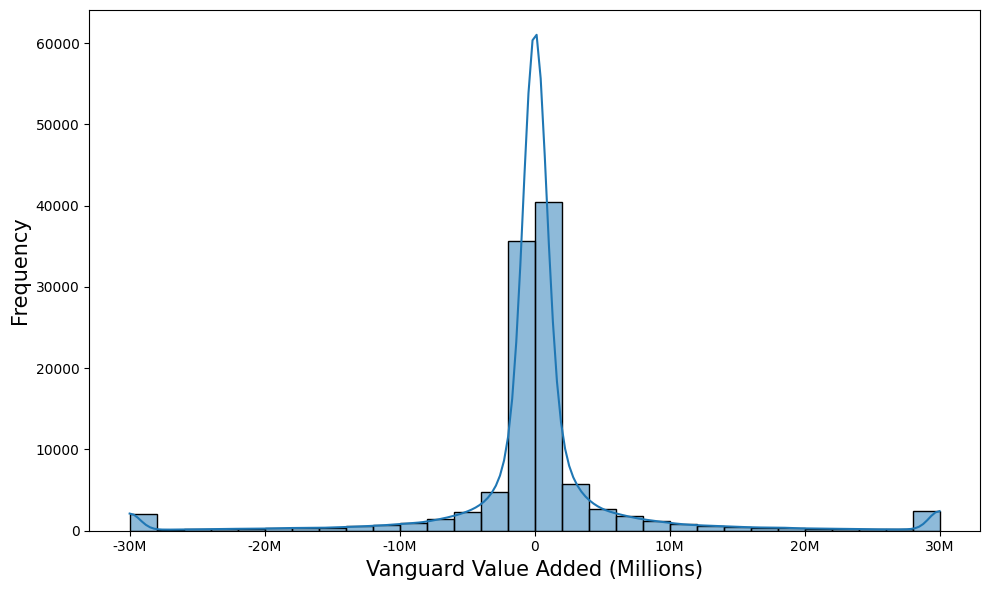

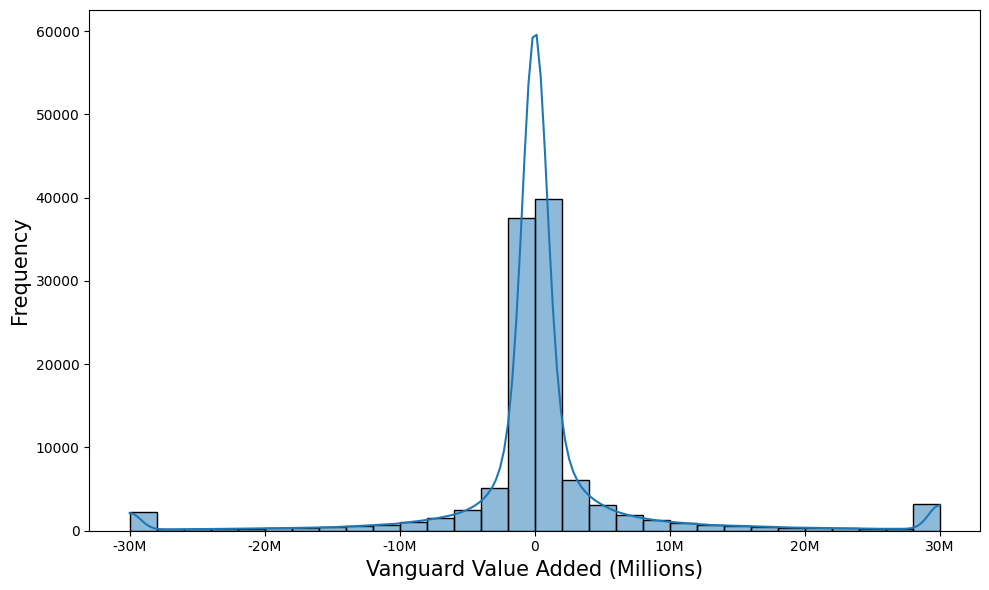

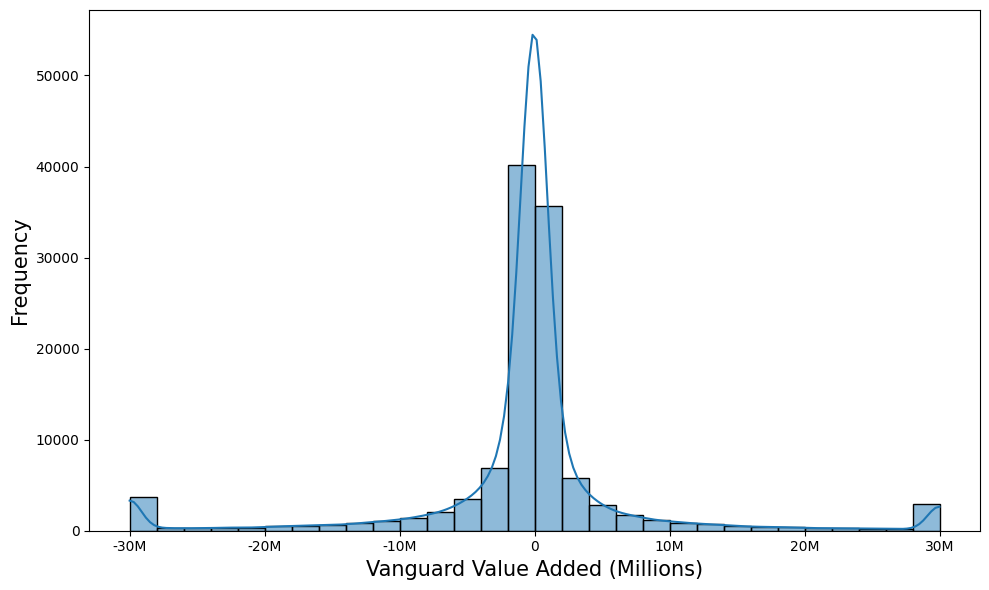

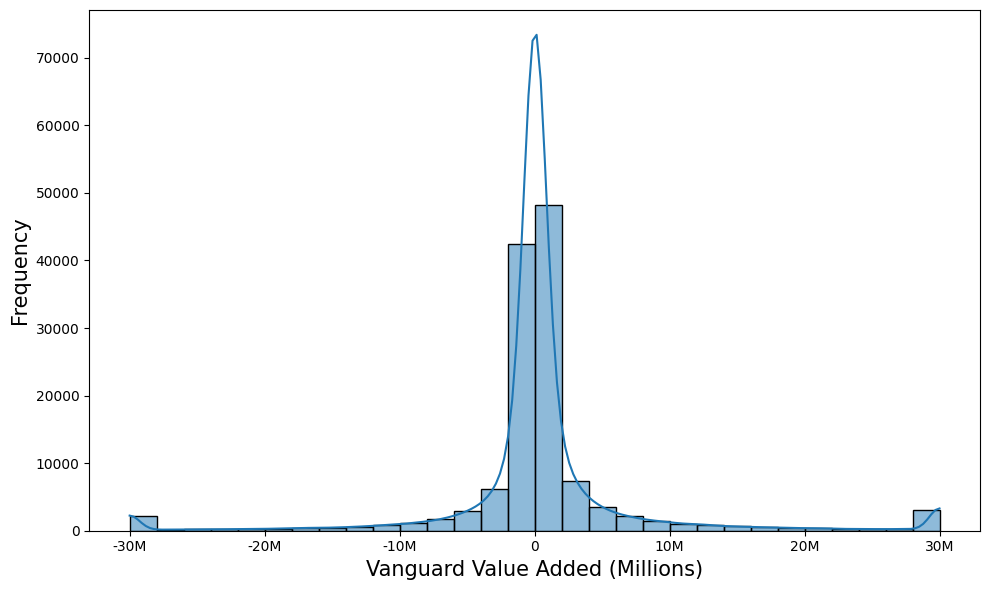

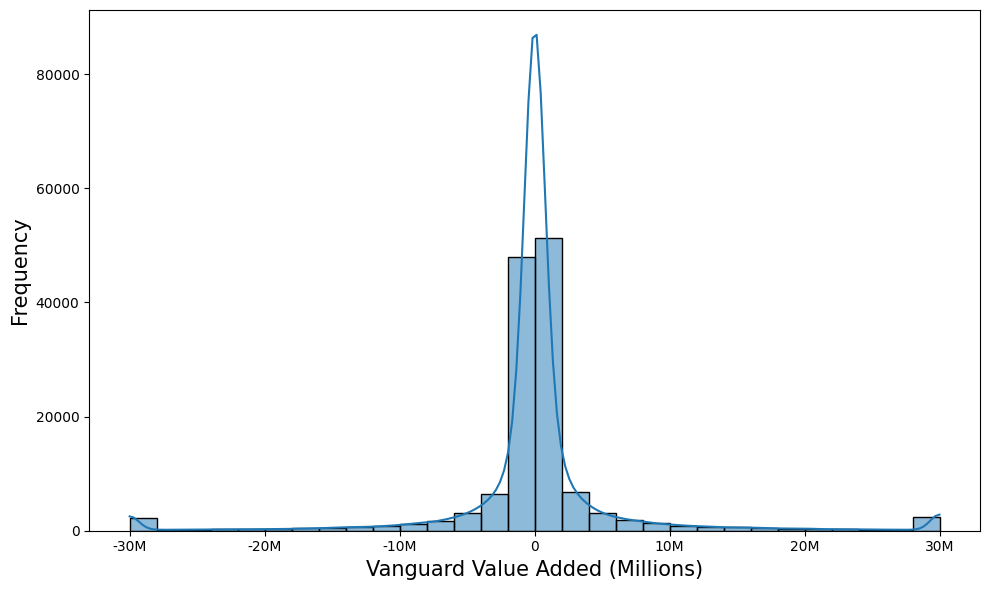

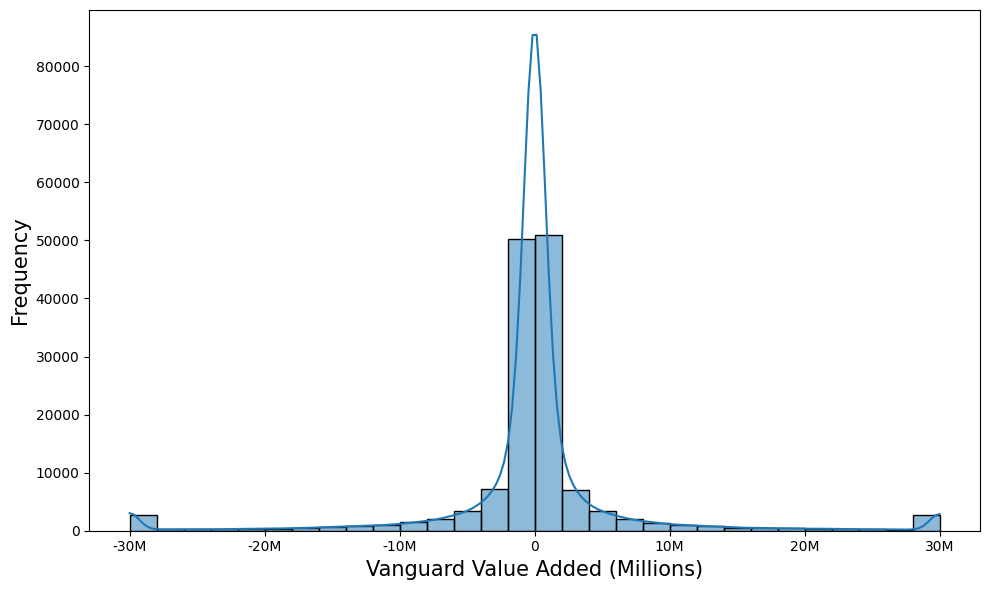

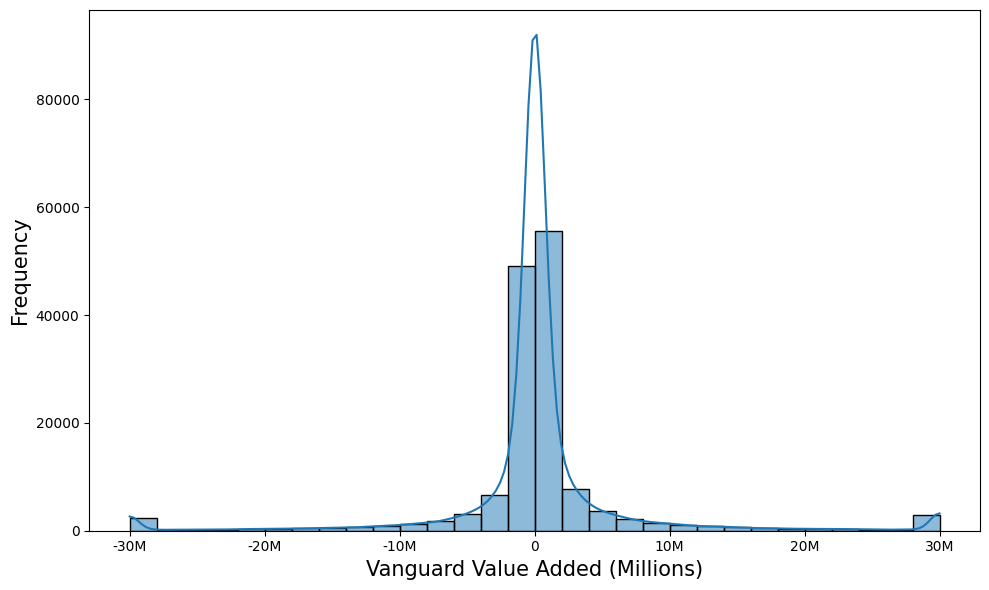

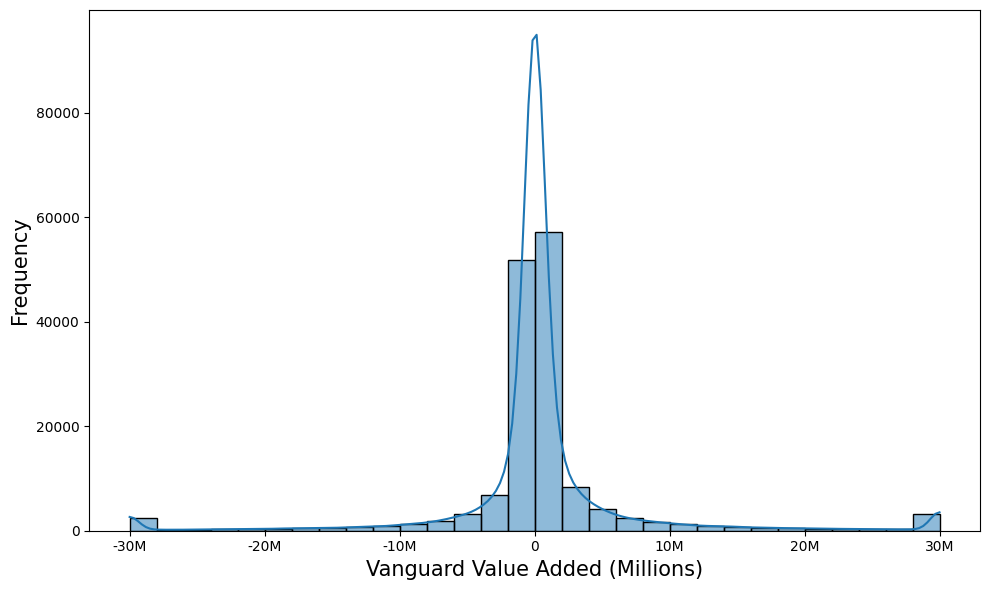

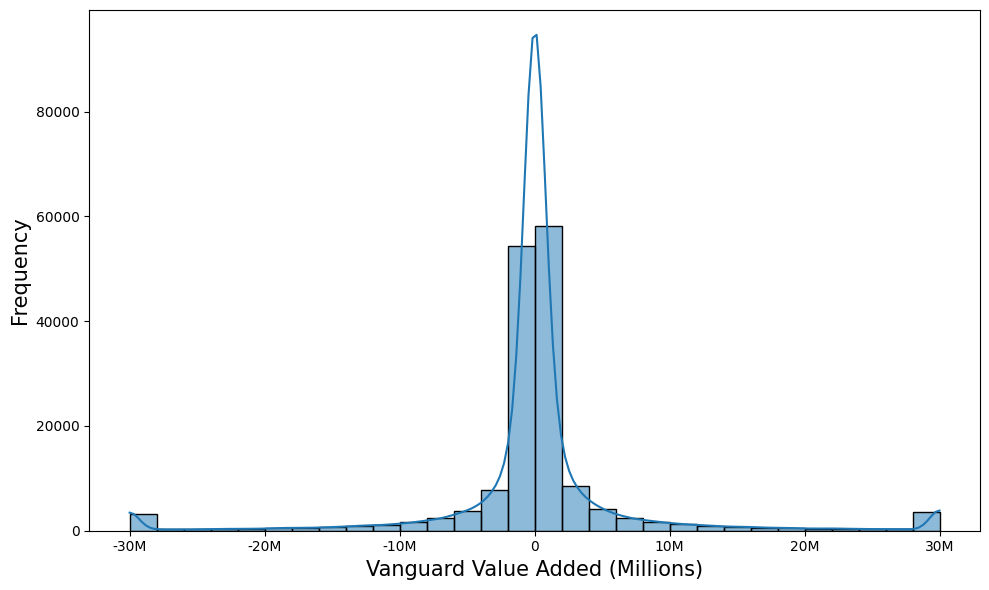

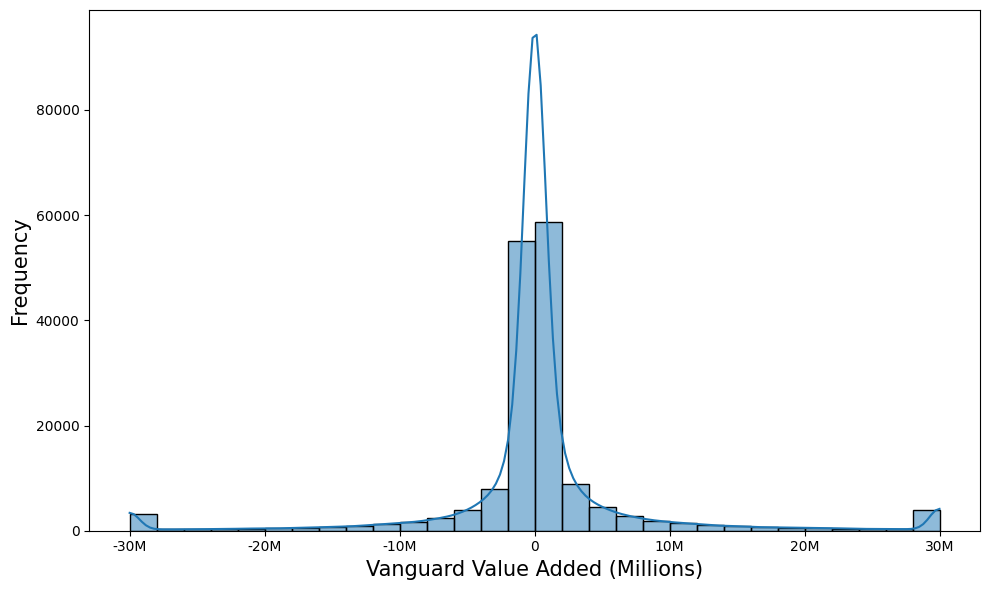

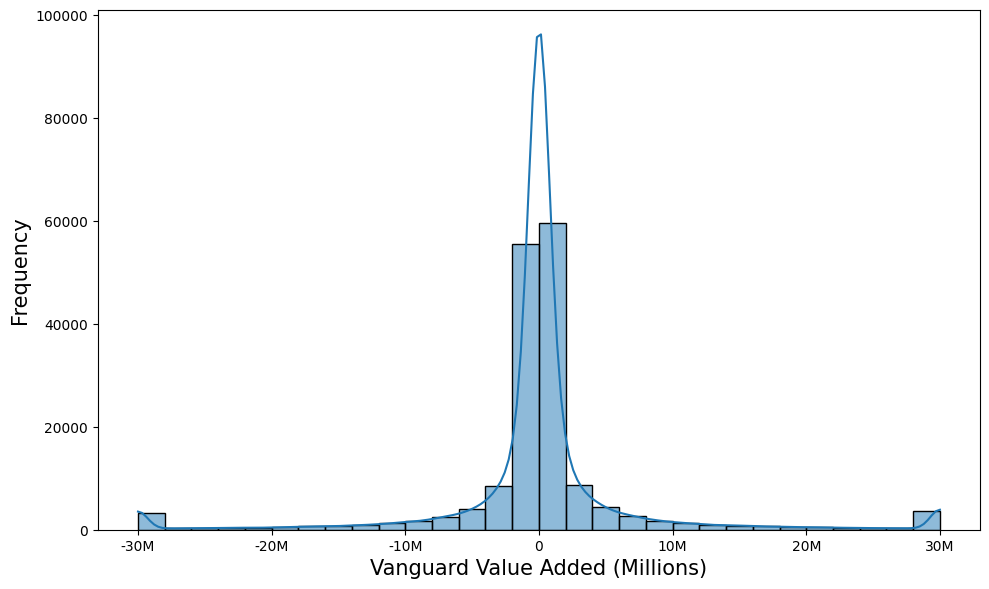

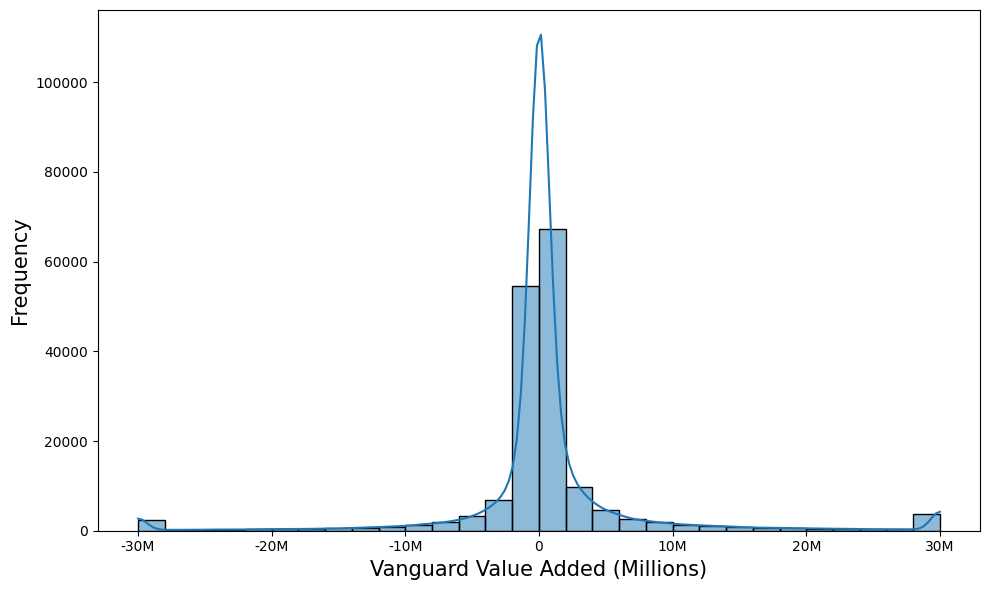

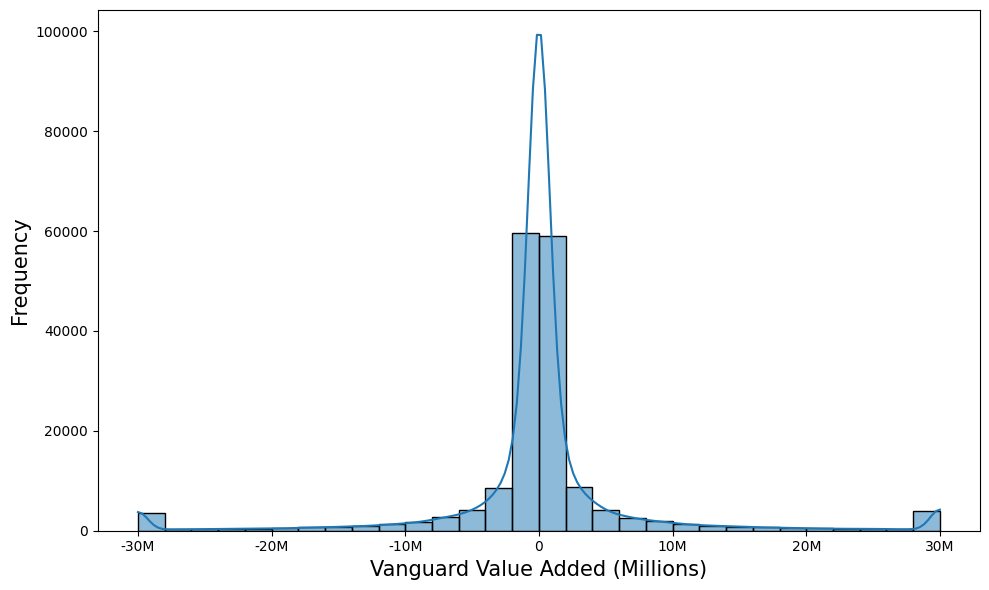

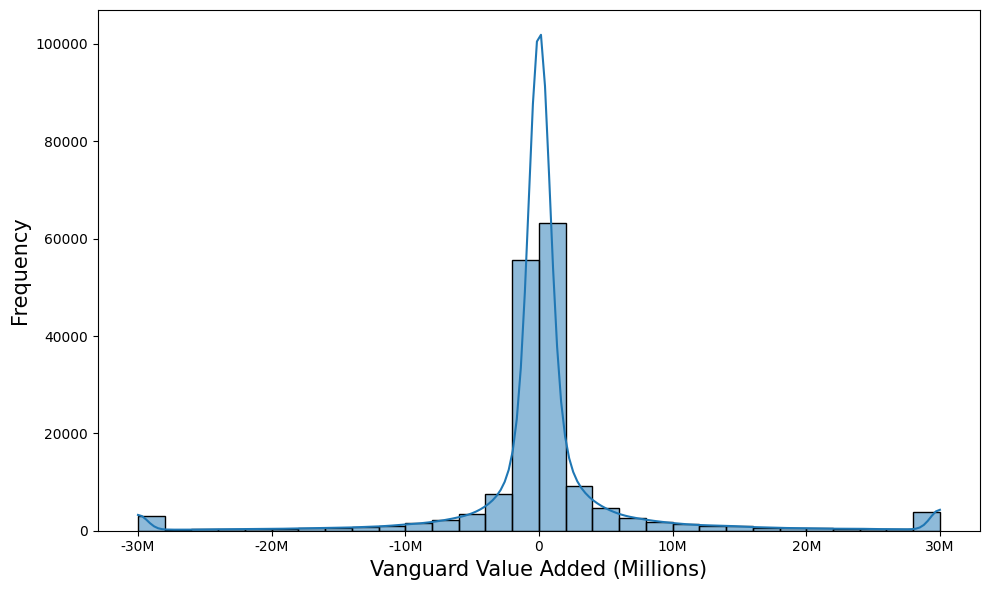

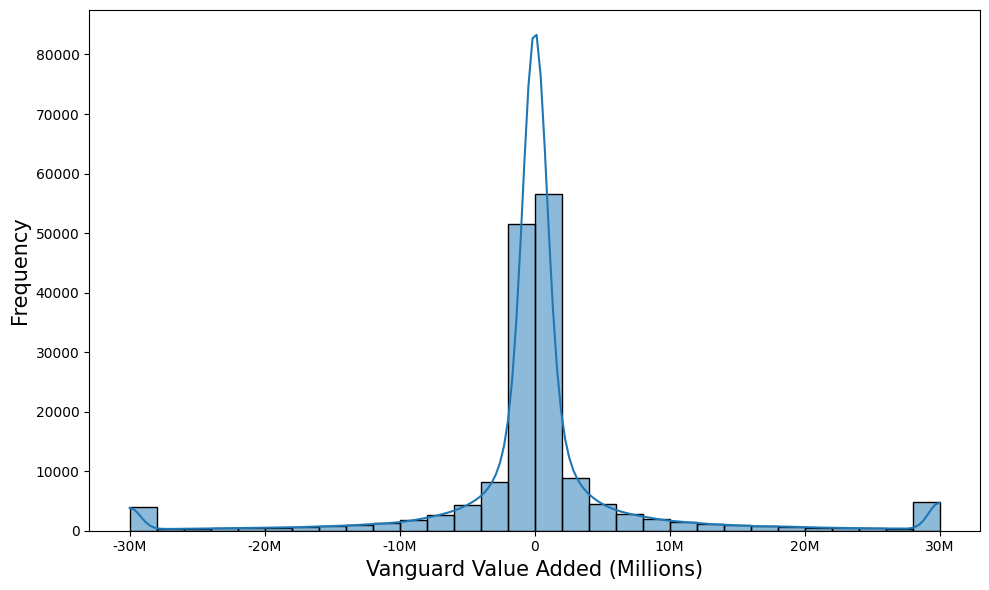

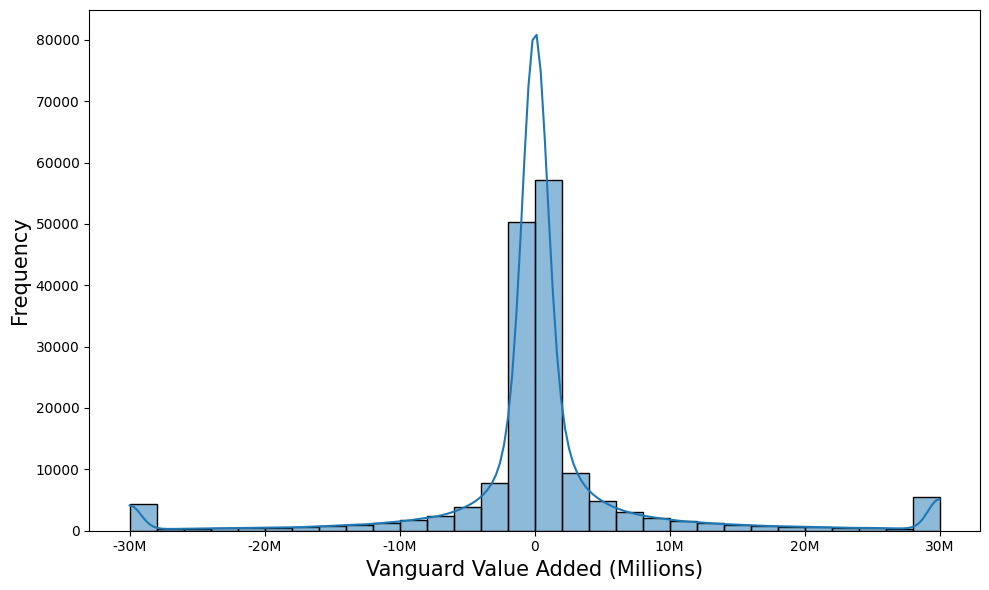

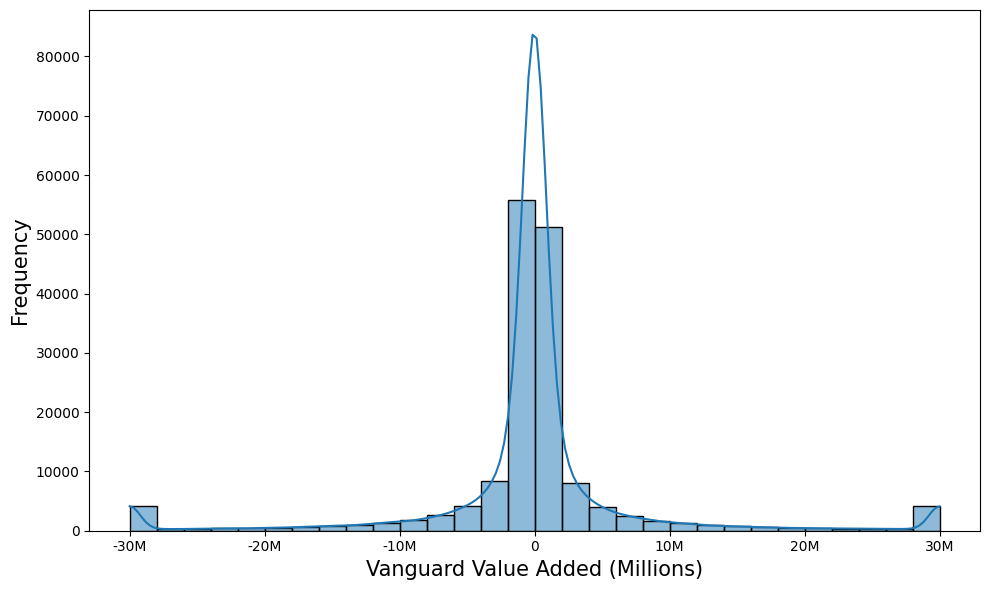

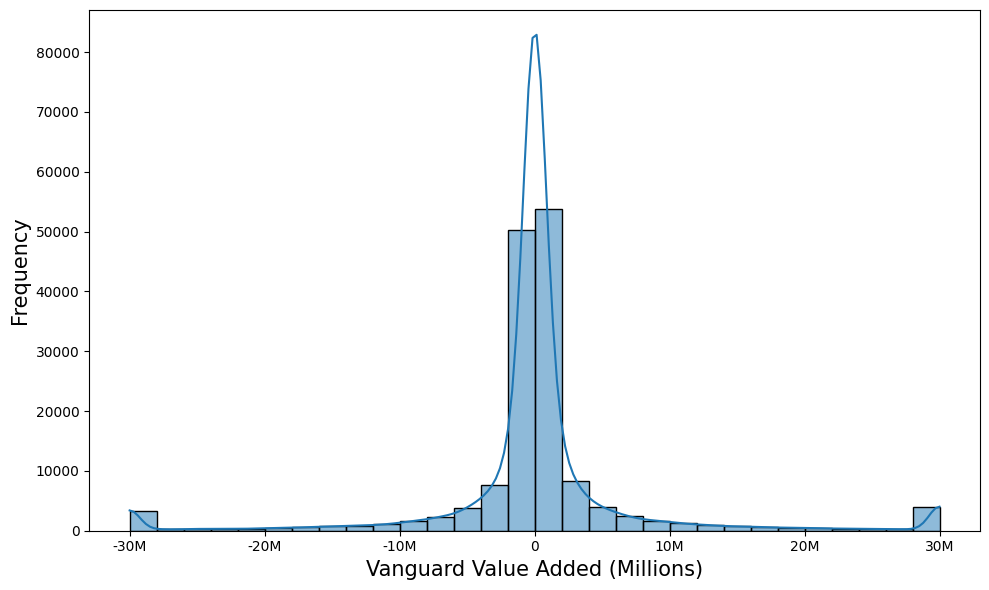

In [8]:
# Function to format x-axis labels in millions
def millions(x, pos):
    'The two args are the value and tick position'
    if x == 0:
        return '0'
    return f'{x * 1e-6:.0f}M'

# Fetch unique years
years = active_funds['year'].unique()

# Plot histograms of Vanguard Value Added for each year, clipped at -100 million and 100 million
for year in sorted(years):
    plt.figure(figsize=(10, 6))
    
    # Clip the values at -100 million and 100 million
    vanguard_va_winsorized = active_funds[active_funds['year'] == year]['vanguard_VA'].clip(lower=-30e6, upper=30e6)
    
    # Create histogram
    sns.histplot(vanguard_va_winsorized, kde=True, bins=30, color='tab:blue')
    
    # Customize plot
    # plt.title(f'Histogram of Vanguard Value Added for Active Funds in {year}', fontsize=20)
    plt.xlabel('Vanguard Value Added (Millions)', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    
    # Format x-axis labels
    ax = plt.gca()
    ax.xaxis.set_major_formatter(FuncFormatter(millions))
    plt.grid(False)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f'figures/vanguard_va_histogram_{year}.pdf')
    plt.show()

In [9]:
def find_matching_substrings(fund_name, substrings):
    return [substring for substring in substrings if substring.lower() in fund_name.lower()]
find_matching_substrings('AIM Funds Group: AIM Premier Equity Fund; Class B Shares', substrings)

[]

In [10]:
passive_funds[passive_funds['year']==2005].sort_values(by='vanguard_VA', ascending=False).head(20)

,crsp_fundno,caldt,mret,mtna,exp_ratio,turn_ratio,fund_name,cma,hml,mktrf,...,mktrf_ff,cma_ff,vanguard_return,vanguard_alpha,vanguard_VA,ff_return,ff_alpha,ff_VA,index,fund_type
1686740,16433,2005-06-30,2.040891,16665.0,0.0035,0.08,iShares Trust: iShares MSCI EAFE Index Fund,-0.0051,0.0283,0.0057,...,0.943864,-0.176396,0.049713,1.991469,5.004333e+10,0.018101,2.023081,5.083770e+10,1,Passive
1477397,16452,2005-06-30,1.077408,7151.0,0.0020,0.20,iShares Trust: iShares Russell 2000 Index Fund,-0.0051,0.0283,0.0057,...,1.120543,-0.276409,0.051322,1.026253,1.106595e+10,0.020043,1.057532,1.140322e+10,1,Passive
1481344,16467,2005-06-30,2.100047,3538.9,0.0020,0.16,iShares Trust: iShares S&P SmallCap 600 Index ...,-0.0051,0.0283,0.0057,...,1.118040,-0.478548,0.067435,2.032778,1.084740e+10,0.030451,2.069763,1.104476e+10,1,Passive
1476839,16450,2005-06-30,2.134934,2854.1,0.0025,0.14,iShares Trust: iShares Russell 2000 Value Inde...,-0.0051,0.0283,0.0057,...,1.072035,-0.372910,0.074125,2.061018,8.869888e+09,0.034688,2.100455,9.039611e+09,1,Passive
1475159,16437,2005-06-30,1.048284,2659.5,0.0020,0.09,iShares Trust: iShares S&P MidCap 400 Index Fund,-0.0051,0.0283,0.0057,...,1.095850,-0.240119,0.048025,1.000426,4.011920e+09,0.019417,1.029034,4.126644e+09,1,Passive
1689143,16443,2005-06-30,1.089425,1588.3,0.0035,0.18,iShares Trust: iShares Cohen & Steers Realty M...,-0.0051,0.0283,0.0057,...,0.925742,-0.126398,0.067363,1.022354,2.448504e+09,0.020244,1.069473,2.561353e+09,1,Passive
1738447,29233,2005-09-30,2.016303,795.2,0.0026,0.11,streetTRACKS Series Trust: streetTRACKS Wilshi...,-0.0060,0.0071,0.0049,...,0.987649,-0.190832,0.108708,1.907812,2.287595e+09,0.010893,2.005626,2.404881e+09,1,Passive
1479636,16460,2005-06-30,1.089444,1206.1,0.0060,0.19,iShares Trust: iShares Dow Jones US Real Estat...,-0.0051,0.0283,0.0057,...,0.919867,-0.176354,0.068108,1.021837,1.858369e+09,0.021584,1.068360,1.942980e+09,1,Passive
1685959,16426,2005-06-30,1.150598,755.3,0.0050,0.08,iShares Trust: iShares Goldman Sachs Natural R...,-0.0051,0.0283,0.0057,...,1.150103,-0.157554,0.073476,1.077539,1.227212e+09,0.031653,1.119362,1.274845e+09,1,Passive
1686743,16433,2005-09-30,0.045520,19865.7,0.0035,0.07,iShares Trust: iShares MSCI EAFE Index Fund,-0.0060,0.0071,0.0049,...,0.943864,-0.176396,0.016026,0.029785,8.922278e+08,0.009057,0.036755,1.100997e+09,1,Passive
